## Load and analyze DMPS @ Zeppelin

In [97]:
import DMPS_functions as fu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime 
import seaborn as sns
import scipy as sc
import glob 
# These lines auto-updates the functions in other packages which is useful if these functions are changed. 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
# Defining the path containg all DMPS data
path = 'C:\\Users\\Lovisa\\Documents\\Courses II\\E_science_tools HT22\\Project\\DATA_ZEP_2010to2020\\'

In [90]:
# Using glob to import the files in "path"
glob.glob(path+'\\*')

['C:\\Users\\Lovisa\\Documents\\Courses II\\E_science_tools HT22\\Project\\DATA_ZEP_2010to2020\\DMPS_and_CPC_2010_QA_QC@STP_HARMONIZED_PT20210207.dat',
 'C:\\Users\\Lovisa\\Documents\\Courses II\\E_science_tools HT22\\Project\\DATA_ZEP_2010to2020\\DMPS_and_CPC_2011_QA_QC@STP_HARMONIZED_PT20210207.dat',
 'C:\\Users\\Lovisa\\Documents\\Courses II\\E_science_tools HT22\\Project\\DATA_ZEP_2010to2020\\DMPS_and_CPC_2012_QA_QC@STP_HARMONIZED_PT20210207.dat',
 'C:\\Users\\Lovisa\\Documents\\Courses II\\E_science_tools HT22\\Project\\DATA_ZEP_2010to2020\\DMPS_and_CPC_2013_QA_QC@STP_HARMONIZED_PT20210207.dat',
 'C:\\Users\\Lovisa\\Documents\\Courses II\\E_science_tools HT22\\Project\\DATA_ZEP_2010to2020\\DMPS_and_CPC_2014_QA_QC@STP_HARMONIZED_PT20210207.dat',
 'C:\\Users\\Lovisa\\Documents\\Courses II\\E_science_tools HT22\\Project\\DATA_ZEP_2010to2020\\DMPS_and_CPC_2015_QA_QC@STP_HARMONIZED_PT20210207.dat',
 'C:\\Users\\Lovisa\\Documents\\Courses II\\E_science_tools HT22\\Project\\DATA_ZEP_2010

In [91]:
# Using the the function load_and_append_DMPS to add column headings, remove 
# data flagged as invalid and package the data in a dataframe
DFs_DMPS = fu.load_and_append_DMPS(path, 
                             name_in_file='DMPS')

['Year', 'Month', 'Day', 'Hour', 'Minute', 'UFCPC', 'CPC3010', 'Ntot', 'unknown4', 'unknown5', 'unknown6', 'unknown7', 'unknown8', '5.0118723e-09', '5.6234133e-09', '6.3095734e-09', '7.0794578e-09', '7.9432823e-09', '8.9125094e-09', '1.0000000e-08', '1.1220185e-08', '1.2589254e-08', '1.4125375e-08', '1.5848932e-08', '1.7782794e-08', '1.9952623e-08', '2.2387211e-08', '2.5118864e-08', '2.8183829e-08', '3.1622777e-08', '3.5481339e-08', '3.9810717e-08', '4.4668359e-08', '5.0118723e-08', '5.6234133e-08', '6.3095734e-08', '7.0794578e-08', '7.9432823e-08', '8.9125094e-08', '1.0000000e-07', '1.1220185e-07', '1.2589254e-07', '1.4125375e-07', '1.5848932e-07', '1.7782794e-07', '1.9952623e-07', '2.2387211e-07', '2.5118864e-07', '2.8183829e-07', '3.1622777e-07', '3.5481339e-07', '3.9810717e-07', '4.4668359e-07', '5.0118723e-07', '5.6234133e-07', '6.3095734e-07', '7.0794578e-07', 'flag']
C:\Users\Lovisa\Documents\Courses II\E_science_tools HT22\Project\DATA_ZEP_2010to2020\DMPS_and_CPC_2010_QA_QC@STP

In [92]:
# Using the function concat_df_DMPS
df_DMPS = fu.concat_df_DMPS(DFs_DMPS)
dict_years_to_df = {"2010_2020":df_DMPS}

In [103]:
# Get a list with the DMPS bin column names as strings 
bin_col_list = fu.get_bin_column_string_list()
print(bin_col_list)

['5.0118723e-09', '5.6234133e-09', '6.3095734e-09', '7.0794578e-09', '7.9432823e-09', '8.9125094e-09', '1.0000000e-08', '1.1220185e-08', '1.2589254e-08', '1.4125375e-08', '1.5848932e-08', '1.7782794e-08', '1.9952623e-08', '2.2387211e-08', '2.5118864e-08', '2.8183829e-08', '3.1622777e-08', '3.5481339e-08', '3.9810717e-08', '4.4668359e-08', '5.0118723e-08', '5.6234133e-08', '6.3095734e-08', '7.0794578e-08', '7.9432823e-08', '8.9125094e-08', '1.0000000e-07', '1.1220185e-07', '1.2589254e-07', '1.4125375e-07', '1.5848932e-07', '1.7782794e-07', '1.9952623e-07', '2.2387211e-07', '2.5118864e-07', '2.8183829e-07', '3.1622777e-07', '3.5481339e-07', '3.9810717e-07', '4.4668359e-07', '5.0118723e-07', '5.6234133e-07', '6.3095734e-07', '7.0794578e-07']


In [ ]:
# Stopped here 22-11-14

In [ ]:
ffffffffff # to break code. Next step is to change bin_col_names_2010_2020 (a list of strings) to bin_col_list

In [6]:

def get_bins(bin_col_names_2010_2020):
    bin_col_names_2010_2020_floats = [float(i)*10**9 for i in bin_col_names_2010_2020]
    bin_cols = np.around(bin_col_names_2010_2020_floats,decimals=3)
    bin_cols = np.asarray(bin_cols)
    bin_cols = [str(x) for x in bin_cols] # Loop over all list things and change them to str 
    return bin_cols

In [7]:
def renameDpColumns(df_DMPS, bin_col_names_2010_2020):
    bin_cols = get_bins(bin_col_names_2010_2020)

    # Rename all columns 
    
    dict_cols_to_goodnames = dict(zip(bin_col_names_2010_2020, bin_cols))
   
    df_DMPS = df_DMPS.rename(dict_cols_to_goodnames, axis=1)
    
    return df_DMPS

In [8]:
df_DMPS = renameDpColumns(df_DMPS, bin_col_names_2010_2020)
df_DMPS.head(10)
print(df_DMPS['flag'].unique())

[0.]


In [9]:
# Make a list of all the "real" diameters

GMDs = ['5.0118723e-09', '5.6234133e-09', '6.3095734e-09',
       '7.0794578e-09', '7.9432823e-09', '8.9125094e-09', '1.0000000e-08',
       '1.1220185e-08', '1.2589254e-08', '1.4125375e-08', '1.5848932e-08',
       '1.7782794e-08', '1.9952623e-08', '2.2387211e-08', '2.5118864e-08',
       '2.8183829e-08', '3.1622777e-08', '3.5481339e-08', '3.9810717e-08',
       '4.4668359e-08', '5.0118723e-08', '5.6234133e-08', '6.3095734e-08',
       '7.0794578e-08', '7.9432823e-08', '8.9125094e-08', '1.0000000e-07',
       '1.1220185e-07', '1.2589254e-07', '1.4125375e-07', '1.5848932e-07',
       '1.7782794e-07', '1.9952623e-07', '2.2387211e-07', '2.5118864e-07',
       '2.8183829e-07', '3.1622777e-07', '3.5481339e-07', '3.9810717e-07',
       '4.4668359e-07', '5.0118723e-07', '5.6234133e-07', '6.3095734e-07',
       '7.0794578e-07']
diameterList = [float(i) for i in GMDs]
diameters = np.asarray(diameterList)
print(diameters.shape)

(44,)


In [10]:
dict_years_to_df = fu.resample_dfs(dict_years_to_df, "2010_2020")

### Resampling 

In [11]:
df_daily_2010_2020_mean = df_DMPS.resample('D').mean()
df_daily_2010_2020_mean = df_daily_2010_2020_mean.dropna(how='all')

df_daily_2010_2020_median = df_DMPS.resample('D').median()
print(len(df_daily_2010_2020_median))
df_daily_2010_2020_median = df_daily_2010_2020_median.dropna(how='all') 
# resample fills the gaps with nan's. All rows where all are equal to nan are dropped

df_hourly_2010_2020_mean = df_DMPS.resample('H').mean()
df_hourly_2010_2020_mean = df_hourly_2010_2020_mean.dropna(how='all')

3804


In [12]:
# df_dmps_for_Kei = df_daily_2010_2020_mean.copy()
# df_dmps_for_Kei.to_csv(r'C:\Users\Lovisa\Documents\GitHub\Tjaernoe2022-group3\data_frame_to_Kei.csv', index = False, header=True)

In [13]:
#df_aug04 = df_DMPS[('2010-08-04' < df_DMPS.index) & (df_DMPS.index < '2010-08-05')]

In [14]:
df_hourly_2010_2020_mean.head()

,UFCPC,CPC3010,Ntot,5.012,5.623,6.31,7.079,7.943,8.913,10.0,...,281.838,316.228,354.813,398.107,446.684,501.187,562.341,630.957,707.946,flag
DateTime,,,,,,,,,,,,,,,,,,,,,
2010-08-03 00:00:00,0.0,192.743870,243.841220,2.808560e-29,2.806373e-29,2.803910e-29,2.801134e-29,2.798005e-29,2.794476e-29,2.790497e-29,...,41.174992,30.989534,24.949570,12.333647,2.245721,0.025513,2.092485e-29,NaN,NaN,0.0
2010-08-03 01:00:00,0.0,182.486285,208.743710,2.807999e-29,2.805812e-29,2.803348e-29,2.800572e-29,2.797443e-29,2.793914e-29,2.789934e-29,...,25.441111,16.356454,11.408104,6.106511,2.259782,1.784399,1.099211e+00,NaN,NaN,0.0
2010-08-03 02:00:00,0.0,141.769720,166.306785,2.806518e-29,2.804331e-29,2.801867e-29,2.799090e-29,2.795960e-29,2.792430e-29,2.788325e-29,...,13.502628,8.935019,2.800536,3.287963,4.104476,0.682179,4.430441e-01,NaN,NaN,0.0
2010-08-03 03:00:00,0.0,214.613150,241.289260,2.805184e-29,2.802996e-29,2.800531e-29,2.797754e-29,2.794624e-29,2.791094e-29,2.787113e-29,...,43.716792,15.603318,16.124321,12.564497,4.945069,0.071439,2.089488e-29,NaN,NaN,0.0
2010-08-08 19:00:00,0.0,172.534855,202.129580,2.803895e-29,2.801706e-29,2.799242e-29,2.796464e-29,2.793333e-29,2.789803e-29,2.785696e-29,...,0.298961,0.005690,0.345479,0.783144,0.922629,0.018367,2.088351e-29,NaN,NaN,0.0


In [15]:
#df_daily_2010_2020_mean[df_daily_2010_2020_mean['flag'] != 0]

In [16]:
#df_daily_2010_2020_median.iloc[0:20, 3:]

In [17]:
#df_daily_2010_2020_mean.iloc[0:20, 3:-1]

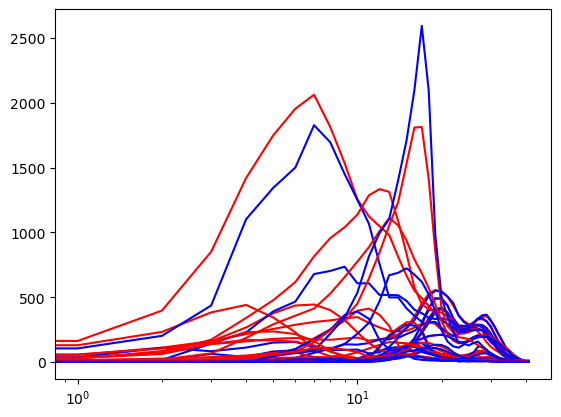

In [18]:
# Plot daily mean distribution
ii = np.arange(0, len(df_daily_2010_2020_mean), 1)

jj = np.arange(7,25,1)

fig, ax = plt.subplots()

for i in jj:
    df_tmp_mean = df_daily_2010_2020_mean.iloc[i, 3:-1].to_frame() # Omit last column with -1 as that is flags
    
    ax.plot(df_tmp_mean.index, df_tmp_mean.values,'r')
    ax.set_xscale('log')
    
    df_tmp_median = df_daily_2010_2020_median.iloc[i,3:-1].to_frame()
    ax.plot(df_tmp_median.index, df_tmp_median.values,'b')
    ax.set_xscale('log')
    
    

## Calculate the bin widths and $N_{tot}$ 

In [19]:
# Check to see that all intervals are equally spaced on a log scale
# np.diff(np.log10(diameters))

In [20]:
# Calculate the bin widths from geometric mean diameters and the total particle number concentration for each year

def calcNtot(diameters, df):
    # Create array to store upper bin boudaries
    upperBoundaries = np.empty(0)
    diameter_list = list(diameters)

    # Create array to store the number concentration in each bin
    dNs = np.empty(0)
    upperLimits = []

    for Dp in range(len(diameter_list)-1):

        # Calulate the upper bin from the geo mean of the midpoint diamters as they are equally spaced on a log scale
        upperLimits.append(np.sqrt( diameter_list[Dp] * diameter_list[Dp+1] ) )

    upperLimits = np.array(upperLimits)

    # Calulate the endpoints, ie the first lower limit and the last upper limit
    firstLimit = diameter_list[0]**2 / upperLimits[0] # This is actually the first lower limit, but its needed for the first binwidth
    lastLimit = diameter_list[-1]**2 / upperLimits[-1]

    upperBoundaries = np.insert(upperLimits, 0, firstLimit) 
    upperBoundaries = np.append(upperBoundaries, lastLimit)

    # Calculate dlogDp from the boundaries
    dlogDp = np.log10(upperBoundaries[1:]) - np.log10(upperBoundaries[:-1])

    # Calculate the particle concentration in each bin (dN) by multiplying dNdlogD with dlogD

    lenDiam = len(diameters)
    idx = len(GMDs)-lenDiam+3

    dNdlogDp = df.iloc[:,idx:-1]
    dNs = dNdlogDp*(dlogDp)
    ntotCalc = dNs.sum(axis=1)    

    df_ntotCalc = df.copy(deep = True)
    df_ntotCalc['NtotCalc'] = ntotCalc
    return df_ntotCalc

In [21]:
df_daily_2010_2020_median_ntotCalc = calcNtot(diameters, df_daily_2010_2020_median)
df_DMPS_ntotCalc = calcNtot(diameters, df_DMPS) # 30 min res
df_hourly_2010_2020_mean_ntotCalc = calcNtot(diameters, df_hourly_2010_2020_mean) # 30 min res

In [22]:
df_daily_2010_2020_median_ntotCalc.head(20)

,UFCPC,CPC3010,Ntot,5.012,5.623,6.31,7.079,7.943,8.913,10.0,...,316.228,354.813,398.107,446.684,501.187,562.341,630.957,707.946,flag,NtotCalc
DateTime,,,,,,,,,,,,,,,,,,,,,
2010-08-03,0.0,182.125050,208.743710,2.807274e-29,2.805087e-29,2.802623e-29,2.799847e-29,2.796717e-29,2.793188e-29,2.789083e-29,...,1.595947e+01,1.140810e+01,6.404960e+00,3.215610e+00,6.580380e-02,3.644812e-02,NaN,NaN,0.0,195.422265
2010-08-08,0.0,208.549030,216.002220,2.803765e-29,2.801642e-29,2.799177e-29,2.796336e-29,2.793333e-29,2.789739e-29,2.785956e-29,...,2.583533e-01,3.454788e-01,7.831442e-01,2.956088e-01,1.836670e-02,2.100116e-29,NaN,NaN,0.0,197.317230
2010-08-09,0.0,154.734860,161.003870,2.806636e-29,2.804662e-29,2.802281e-29,2.801081e-29,8.042767e-02,1.139879e+01,1.247090e+01,...,2.046894e+00,1.640962e+00,1.104209e+00,6.720334e-01,3.448541e-01,3.823051e-01,NaN,NaN,0.0,129.073125
2010-08-10,0.0,134.719790,131.968835,2.810195e-29,2.808443e-29,2.512165e+00,1.344979e+00,9.600177e-01,3.076694e+01,4.277998e+01,...,1.163181e+00,2.004981e+00,1.831223e+00,1.312853e+00,6.538213e-01,8.970167e-01,NaN,NaN,0.0,109.282715
2010-08-11,0.0,238.900390,235.042670,2.816689e-29,2.814186e-29,2.812867e-29,2.813508e-29,1.201330e+00,4.388591e+01,7.954211e+01,...,2.129925e+00,2.208846e+00,1.974385e+00,1.572773e+00,1.200883e+00,9.980769e-01,NaN,NaN,0.0,209.785219
2010-08-12,0.0,217.511540,210.367135,2.809073e-29,2.811712e-29,2.809459e-29,2.810912e-29,2.988597e-01,2.759165e+01,3.907844e+01,...,3.029406e+00,2.734418e+00,2.293894e+00,1.758534e+00,1.196882e+00,1.270764e+00,NaN,NaN,0.0,178.575169
2010-08-13,0.0,345.619480,365.804310,2.804068e-29,2.803278e-29,2.806286e-29,9.656931e-01,2.395757e-01,2.280036e+01,3.302152e+01,...,2.013338e+00,2.162721e+00,1.652657e+00,1.387767e+00,7.904804e-01,1.037931e+00,NaN,NaN,0.0,347.025333
2010-08-17,0.0,73.230619,90.965196,2.798339e-29,2.796429e-29,2.793905e-29,2.791786e-29,2.792821e-29,2.788836e-29,9.372879e-01,...,2.347158e-29,2.291268e-29,2.239401e-29,2.190885e-29,2.146085e-29,2.103895e-29,NaN,NaN,0.0,44.688033
2010-08-18,0.0,253.924260,274.264120,2.818039e-29,3.566908e+01,1.086134e+02,8.241685e+01,1.104258e+02,1.488785e+02,1.534663e+02,...,2.435447e+01,1.159827e+01,6.361371e+00,3.276498e+00,1.181661e+00,8.864701e-01,NaN,NaN,0.0,288.351084


In [23]:
cols = df_daily_2010_2020_median.columns[3:-1]

In [24]:
diameter_list = list(diameters) 
df_daily_2010_2020_median[cols]

,5.012,5.623,6.31,7.079,7.943,8.913,10.0,11.22,12.589,14.125,...,251.189,281.838,316.228,354.813,398.107,446.684,501.187,562.341,630.957,707.946
DateTime,,,,,,,,,,,,,,,,,,,,,
2010-08-03,2.807274e-29,2.805087e-29,2.802623e-29,2.799847e-29,2.796717e-29,2.793188e-29,2.789083e-29,2.784506e-29,2.779898e-29,2.528172,...,36.805352,25.441111,15.959473,11.408104,6.404960,3.215610,6.580380e-02,3.644812e-02,NaN,NaN
2010-08-08,2.803765e-29,2.801642e-29,2.799177e-29,2.796336e-29,2.793333e-29,2.789739e-29,2.785956e-29,2.781377e-29,1.980118e+01,95.843733,...,1.347548,0.582094,0.258353,0.345479,0.783144,0.295609,1.836670e-02,2.100116e-29,NaN,NaN
2010-08-09,2.806636e-29,2.804662e-29,2.802281e-29,2.801081e-29,8.042767e-02,1.139879e+01,1.247090e+01,2.386696e+01,5.317039e+01,44.253335,...,6.824198,4.120078,2.046894,1.640962,1.104209,0.672033,3.448541e-01,3.823051e-01,NaN,NaN
2010-08-10,2.810195e-29,2.808443e-29,2.512165e+00,1.344979e+00,9.600177e-01,3.076694e+01,4.277998e+01,6.963213e+01,1.180271e+02,115.314160,...,2.201041,1.821533,1.163181,2.004981,1.831223,1.312853,6.538213e-01,8.970167e-01,NaN,NaN
2010-08-11,2.816689e-29,2.814186e-29,2.812867e-29,2.813508e-29,1.201330e+00,4.388591e+01,7.954211e+01,1.319526e+02,2.299151e+02,359.763670,...,3.949737,3.182375,2.129925,2.208846,1.974385,1.572773,1.200883e+00,9.980769e-01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,4.856011e-29,4.852284e-29,4.849348e-29,4.847406e-29,4.842079e-29,1.124949e-01,4.242500e+00,4.548924e+00,6.194749e+00,7.793845,...,13.867514,12.961275,10.035624,7.545087,4.860186,6.319750,5.246771e+00,4.236436e+00,5.858947e-01,1.829243e+00
2020-12-28,NaN,4.883492e-29,4.898032e-29,4.886053e-29,4.880367e-29,4.892914e-29,2.828007e+00,4.719816e+00,8.951490e+00,12.309525,...,48.724140,30.998753,26.608241,20.886540,11.484529,7.620646,6.249617e+00,5.127825e+00,2.445025e+00,1.705581e+00
2020-12-29,NaN,4.924687e-29,4.921681e-29,4.920744e-29,4.915452e-29,3.734622e-01,2.861616e+00,4.430043e+00,8.259293e+00,11.333296,...,18.791206,13.295481,8.799040,5.236407,0.004128,0.425705,1.802560e-29,1.766702e-29,1.734943e-29,1.705079e-29


In [25]:
# Check that boundries are correct

# ys = [0,10]

# fig, ax = plt.subplots()
# for i in range(len(diameters)):
#     ls = [diameters[i], diameters[i]]
#     ax.plot(ls,ys,'r:')
#     ax.set_xscale('log')
    
# for i in range(len(upperBoundaries)):
#     ls2 = [upperBoundaries[i],upperBoundaries[i]]
#     ax.plot(ls2,ys,'b')
    


In [26]:
# ls = [diameters[i], diameters[i]]
# print(ls)

### N_tot from CPC vs calclated N_tot

R-squared: 0.999363


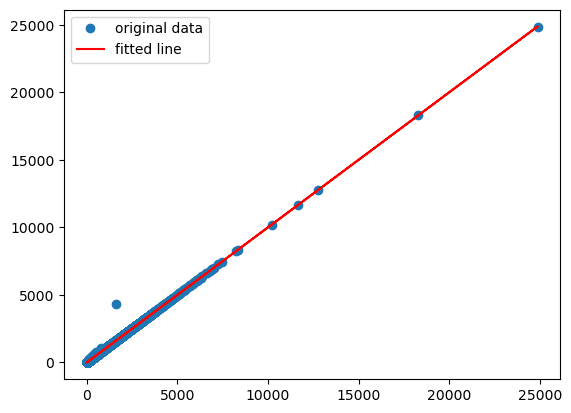

0.0445901316076629
1.0004705430431775


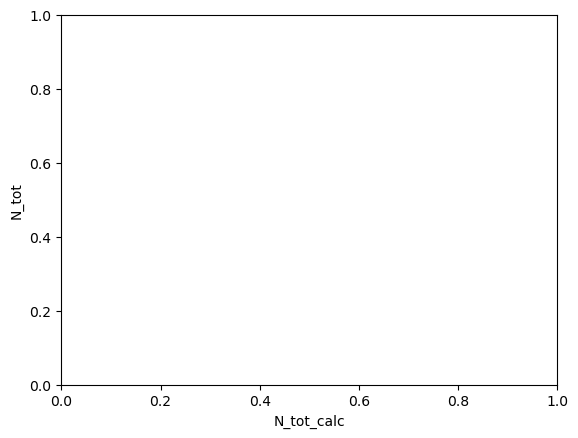

In [27]:
varx = df_hourly_2010_2020_mean_ntotCalc['NtotCalc'].values
vary = df_hourly_2010_2020_mean_ntotCalc['Ntot'].values

mask = ~np.isnan(varx) & ~np.isnan(vary)
res = sc.stats.linregress(varx[mask], vary[mask])

print(f"R-squared: {res.rvalue**2:.6f}")

plt.plot(varx,
         vary,
         'o', label='original data')
plt.plot(varx,
         res.intercept + res.slope*varx,
         'r-', label='fitted line')
plt.legend()
plt.show()    
plt.ylabel('N_tot')
plt.xlabel('N_tot_calc')
print(res.intercept)
print(res.slope)

### Compare $N_{D_P <x}/N_{tot}$ and UFCPC/CPC

In [28]:
# Compare the area up to x nm with total area 
# Vary the threshold diameter x

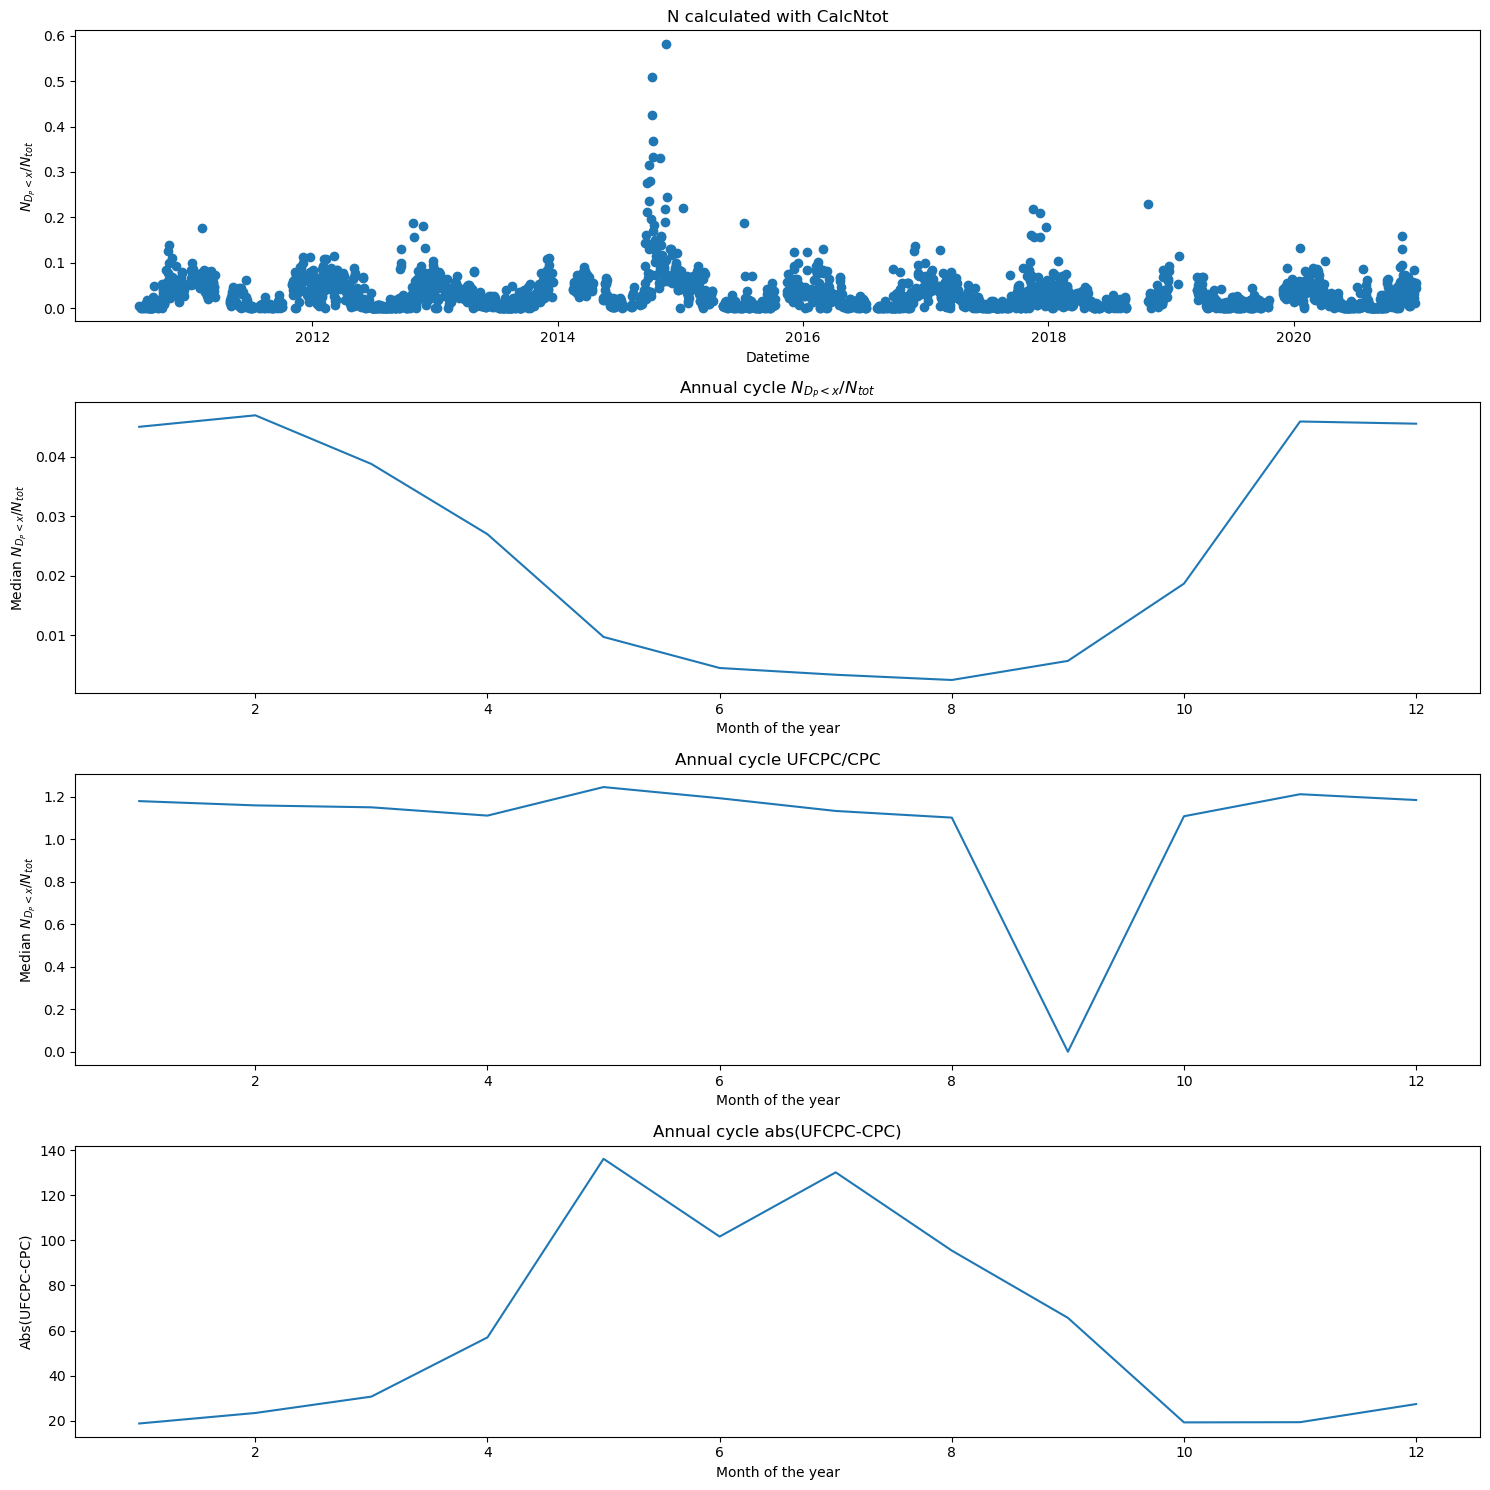

In [29]:
threshold = 10

bin_cols = get_bins(bin_col_names_2010_2020)
#print(bin_cols)
bin_cols = [float(x) for x in bin_cols]
bin_cols = [x for x in bin_cols if x < threshold]
#print(bin_cols)

# df changes
df_daily_2010_2020_median_copy = df_daily_2010_2020_median.copy(deep = True)
df_tmp = calcNtot(diameters[:len(bin_cols)+1], df_daily_2010_2020_median_copy)

# Plot Nx/Ntot
NxNtot = df_tmp['NtotCalc'].values/df_tmp['Ntot'].values

fig, axs = plt.subplots(4,figsize=(15, 15))

axs[0].plot(df_tmp.index,NxNtot,'o')
axs[0].set_xlabel('Datetime')
axs[0].set_ylabel('$N_{D_P < x}/N_{tot}$')
axs[0].set_title('N calculated with CalcNtot')

df_tmp['NxNtot'] = df_tmp['NtotCalc']/df_tmp['Ntot']
df_annual_cycle = df_tmp['NxNtot'].groupby(df_tmp.index.month).median()

axs[1].plot(df_annual_cycle.index, df_annual_cycle.values)
axs[1].set_xlabel('Month of the year')
axs[1].set_ylabel('Median $N_{D_P < x}/N_{tot}$')
axs[1].set_title('Annual cycle $N_{D_P < x}/N_{tot}$ ')

df_tmp['ratio_CPCs'] = df_tmp['UFCPC']/df_tmp['CPC3010']
df_annual_cycle_CPC = df_tmp['ratio_CPCs'].groupby(df_tmp.index.month).median()

axs[2].plot(df_annual_cycle_CPC.index, df_annual_cycle_CPC.values)
axs[2].set_xlabel('Month of the year')
axs[2].set_ylabel('Median $N_{D_P < x}/N_{tot}$')
axs[2].set_title('Annual cycle UFCPC/CPC')

# Diffs are so small so ratio is bad, abs diff is better
absDiffCPCs = np.absolute(df_tmp['UFCPC'].values - df_tmp['CPC3010'].values)
df_tmp['AbsDiffCPCs'] = absDiffCPCs
df_annual_cycle_abs = df_tmp['AbsDiffCPCs'].groupby(df_tmp.index.month).median()

axs[3].plot(df_annual_cycle_abs.index, df_annual_cycle_abs.values)
axs[3].set_xlabel('Month of the year')
axs[3].set_ylabel('Abs(UFCPC-CPC)')
axs[3].set_title('Annual cycle abs(UFCPC-CPC)')

plt.tight_layout()

### Plot daily comparison of $N_{D_P <x}/N_{tot}$ and UFCPC/CPC

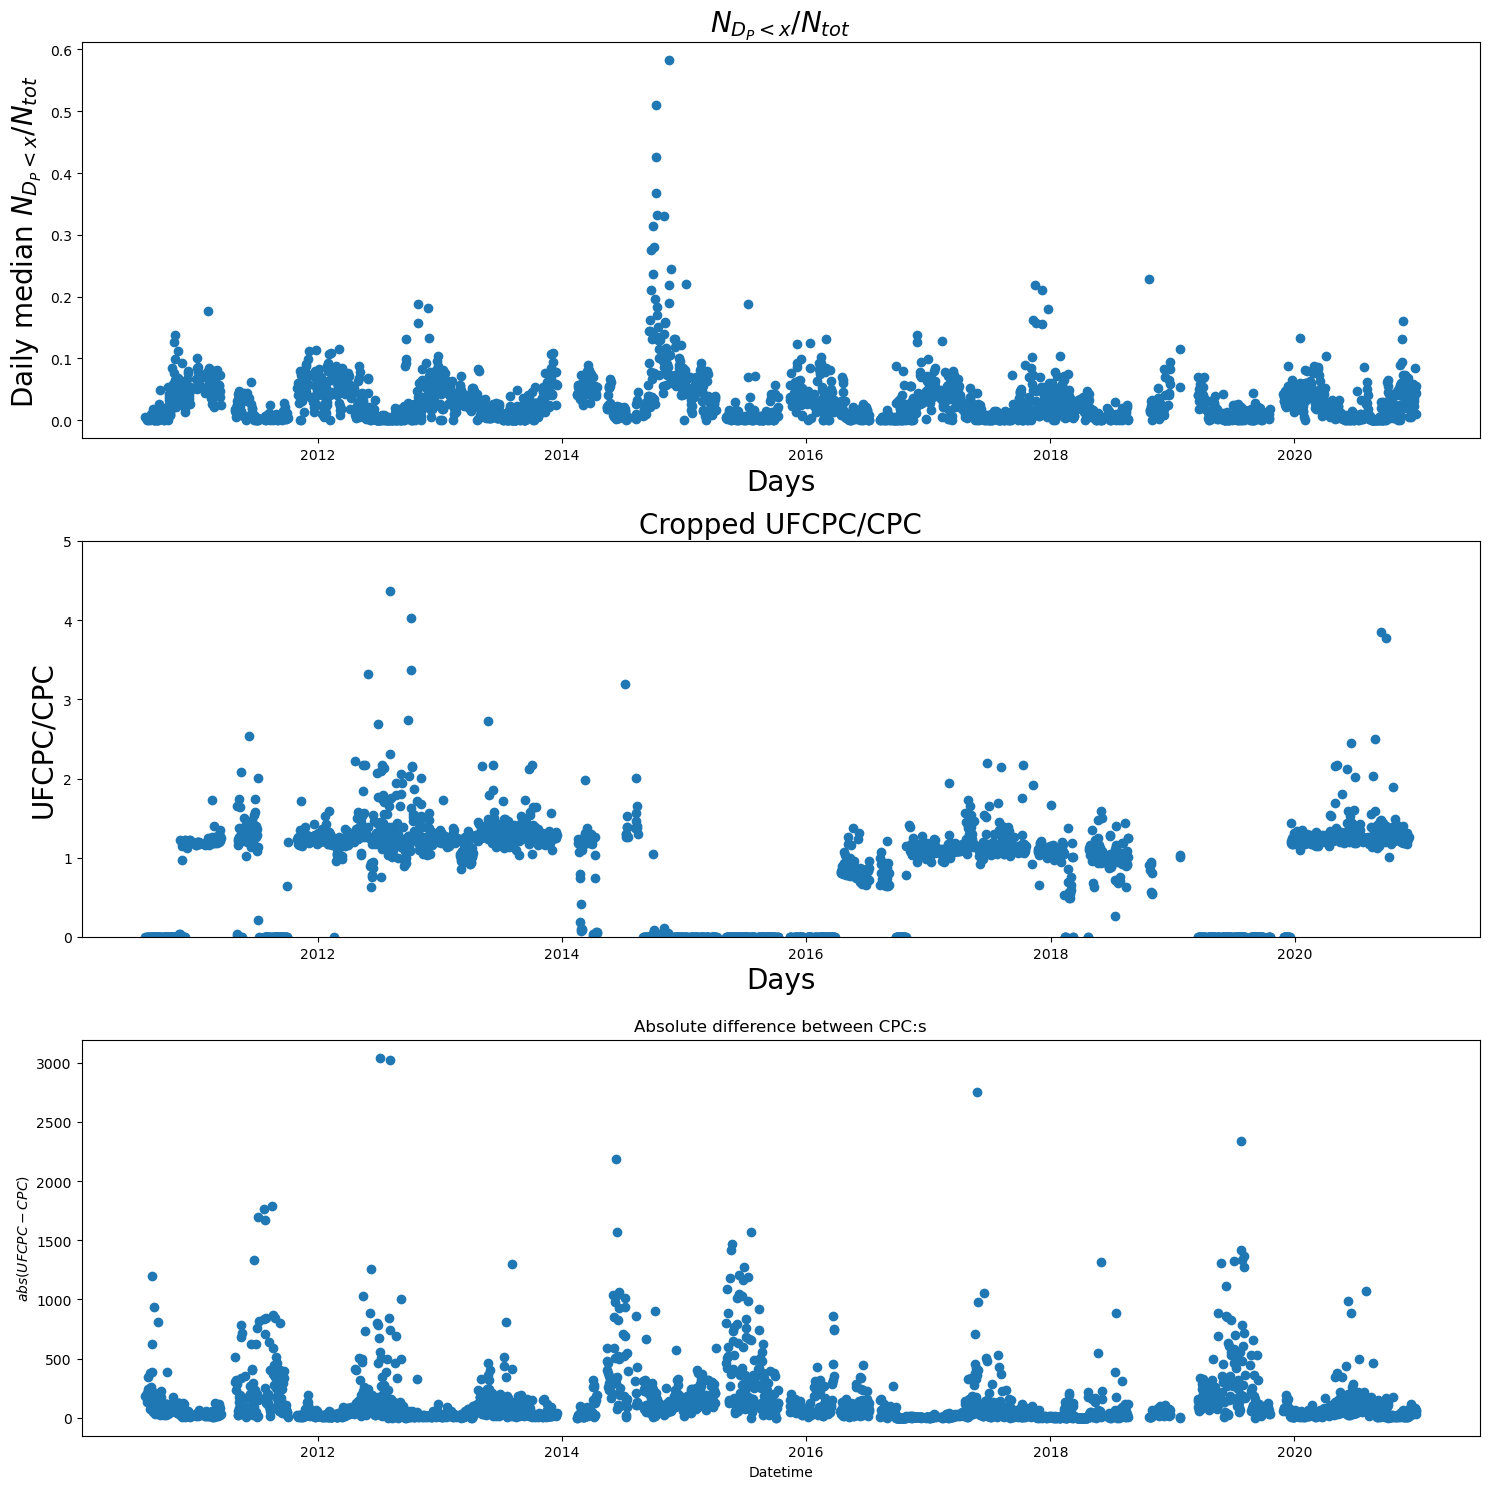

In [30]:
# Plot Nx/Ntot

fig, axs = plt.subplots(3, figsize=(15, 15))

axs[0].plot(df_tmp.index,df_tmp['NxNtot'].values,'o')
axs[0].set_xlabel('Days',fontsize=20)
axs[0].set_ylabel('Daily median $N_{D_P < x}/N_{tot}$',fontsize=20)
axs[0].set_title('$N_{D_P < x}/N_{tot}$',fontsize=20)

df_tmp['ratio_CPCs'] = df_tmp['UFCPC']/df_tmp['CPC3010']
df_annual_cycle_CPC = df_tmp['ratio_CPCs'].groupby(df_tmp.index.month).median()

axs[1].plot(df_tmp.index, df_tmp['ratio_CPCs'].values,'o')
axs[1].set_xlabel('Days',fontsize=20)
axs[1].set_ylabel('UFCPC/CPC',fontsize=20)
axs[1].set_title('Cropped UFCPC/CPC',fontsize=20)
axs[1].set_ylim([0, 5])

axs[2].plot(df_tmp.index,absDiffCPCs,'o')
axs[2].set_xlabel('Datetime')
axs[2].set_ylabel('$abs(UF CPC - CPC)$')
axs[2].set_title('Absolute difference between CPC:s')


plt.tight_layout()

## Clustering 

In [31]:
from sklearn import metrics
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import KMeans

#### Function to normalize the size distributions before clustering

In [32]:
def create_normalised_df(dataFrame, start_size_bin_col='5.012', end_size_bin_col='707.946'):
    df = dataFrame.copy()
    
    n_vars = ['norm'+str(df.loc[:, start_size_bin_col:end_size_bin_col].columns.tolist()[i]) for i in range(0, df.loc[:, start_size_bin_col:end_size_bin_col].shape[1])]
    print(n_vars)
    #divide by maximum
    df[n_vars] = df.loc[:, start_size_bin_col:end_size_bin_col].div(df.loc[:, start_size_bin_col:end_size_bin_col].max(axis=1), axis=0)
    
    df = df.loc[df.loc[:,start_size_bin_col:end_size_bin_col].dropna().index]
    
    Datetime_index = df.index    
    df.reset_index(drop=True, inplace=True)
    #print("Size of df after removing np.nan: "+str(len(df)))
    
    start_size_normbin_col = 'norm'+str(start_size_bin_col)
    end_size_normbin_col = 'norm'+str(end_size_bin_col)    
    
    df_norm = df.loc[:, start_size_normbin_col:end_size_normbin_col].copy()
    df_norm.index = Datetime_index
    df.index = Datetime_index
    
    print("Shape of df_norm: "+str(df_norm.shape))
    print("Shape of df: "+str(df.shape))
    return df, df_norm

#### Function to perform clustering of normalized size distributions

In [33]:
def perform_clustering(df_normarlised, n_clusters):
    kmeans = KMeans(init="k-means++", n_clusters=n_clusters).fit(df_normarlised) #Compute k-means clustering.
    labels = kmeans.labels_
    centres = kmeans.cluster_centers_
    
    # Predict the closest cluster each sample in X belongs to and add a column in the dataframe called clusters
    df_normarlised['clusters'] = kmeans.predict(df_normarlised) 
    
    df_normalized_copy = df_normarlised.copy()
    print(df_normalized_copy['clusters'].unique())    
    
    df_normalized_copy['clusters'] = df_normalized_copy['clusters']+1
    print(df_normalized_copy['clusters'].unique())
    
    dict_max_columns_unordered, dict_max_columns = produce_dicts_for_sorting(df_normalized_copy)
    final_mapping = connect_dicts(dict_max_columns_unordered, dict_max_columns)
    
    df_normalized_copy['clusters'] = df_normalized_copy['clusters'].map(final_mapping)
    
    print(df_normalized_copy['clusters'].unique())
    
    return df_normalized_copy

In [34]:
def produce_dicts_for_sorting(df):
    df_ = df.groupby('clusters').mean()
    max_col_index = df_.apply(lambda x: x.argmax(), axis=1)
    dict_max_columns_unordered = dict(zip(df_.index, max_col_index))
    max_col_index_sorted = sorted(max_col_index.values)
    dict_max_columns = dict(zip(df_.index, max_col_index_sorted))
    print(dict_max_columns)
    return dict_max_columns_unordered, dict_max_columns

In [35]:
# dict_max_columns_unordered, dict_max_columns = produce_dicts_for_sorting(df)
# final_mapping = connect_dicts(dict_max_columns_unordered, dict_max_columns)

In [36]:
def connect_dicts(dict_max_columns_unordered, dict_max_columns):
    final_mapping = {}
    for k,v in dict_max_columns_unordered.items():
        ordered_v = dict_max_columns[k]
        ordered_v_list = list(dict_max_columns.values())
        new_key = ordered_v_list.index(v)+1    
        final_mapping[k] = new_key
    print("the mapping from clustering to ordered clusters (by mode): "+str(final_mapping))
    return final_mapping

In [37]:
#final_mapping = connect_dicts(dict_max_columns_unordered, dict_max_columns)

In [38]:
# df_ = df.groupby('clusters').mean()
# print(df_)
# df_['Max'] = df_.idxmax(axis=1)
# dict_max_columns = dict(zip(df_.index, df_['Max'].values))
# print(dict_max_columns)

In [39]:
#df_

In [40]:
# df_ = df.groupby('clusters').mean()
# print(df_)
# max_values = df_.max(axis=1)
# print(max_values)
# for max_value in max_values:
#     print(max_value)


In [41]:
#dfx = renameClusters(df_norm_clustered_1h_mean)

#print(tmp = df[1,:]) norm5.623      0.130880

In [42]:
# Calling function to normalize size distributions 

df1, df_daily_2010_2020_median_norm = create_normalised_df(df_daily_2010_2020_median)
df2, df_daily_2010_2020_mean_norm = create_normalised_df(df_daily_2010_2020_mean)
df3, df_daily_2010_2020_1h_mean_norm = create_normalised_df(df_hourly_2010_2020_mean)


['norm5.012', 'norm5.623', 'norm6.31', 'norm7.079', 'norm7.943', 'norm8.913', 'norm10.0', 'norm11.22', 'norm12.589', 'norm14.125', 'norm15.849', 'norm17.783', 'norm19.953', 'norm22.387', 'norm25.119', 'norm28.184', 'norm31.623', 'norm35.481', 'norm39.811', 'norm44.668', 'norm50.119', 'norm56.234', 'norm63.096', 'norm70.795', 'norm79.433', 'norm89.125', 'norm100.0', 'norm112.202', 'norm125.893', 'norm141.254', 'norm158.489', 'norm177.828', 'norm199.526', 'norm223.872', 'norm251.189', 'norm281.838', 'norm316.228', 'norm354.813', 'norm398.107', 'norm446.684', 'norm501.187', 'norm562.341', 'norm630.957', 'norm707.946']
Shape of df_norm: (1491, 44)
Shape of df: (1491, 92)
['norm5.012', 'norm5.623', 'norm6.31', 'norm7.079', 'norm7.943', 'norm8.913', 'norm10.0', 'norm11.22', 'norm12.589', 'norm14.125', 'norm15.849', 'norm17.783', 'norm19.953', 'norm22.387', 'norm25.119', 'norm28.184', 'norm31.623', 'norm35.481', 'norm39.811', 'norm44.668', 'norm50.119', 'norm56.234', 'norm63.096', 'norm70.795

In [43]:
#df_hourly_2010_2020_mean.head()

#### Check that are normalized (only snapshots)

In [44]:
# jj = np.arange(7,25,1)

# fig, ax = plt.subplots()

# for i in jj:
#     df_tmp_norm = df_daily_2010_2020_median_norm.iloc[i,:].to_frame() # Omit last column with -1 as that is flags
    
#     ax.plot(diameters*10**9, df_tmp_norm.values,'r')
#     ax.set_xscale('log')


#### Cluster daily median and mean data and 1h hour mean

##### Define the number of clusters 

In [45]:
n_clusters = 5

In [46]:
df_norm_clustered_median = perform_clustering(df_daily_2010_2020_median_norm, n_clusters)
df_norm_clustered_mean = perform_clustering(df_daily_2010_2020_mean_norm, n_clusters)

# 1 hour data needs special treatment:
# Drop the 1st and two last bins before clustering
df_hourly_norm_dropped = df_daily_2010_2020_1h_mean_norm.copy()
df_hourly_norm_dropped = df_hourly_norm_dropped.drop \
                         (columns=['norm5.012','norm630.957','norm707.946'])

df_norm_clustered_1h_mean = perform_clustering(df_hourly_norm_dropped, n_clusters)
print(df_norm_clustered_1h_mean['clusters'].unique())

[0 4 2 1 3]
[1 5 3 2 4]
{1: 11, 2: 15, 3: 27, 4: 30, 5: 32}
the mapping from clustering to ordered clusters (by mode): {1: 5, 2: 2, 3: 3, 4: 1, 5: 4}
[5 4 3 2 1]
[1 4 0 2 3]
[2 5 1 3 4]
{1: 9, 2: 15, 3: 28, 4: 30, 5: 32}
the mapping from clustering to ordered clusters (by mode): {1: 3, 2: 5, 3: 2, 4: 1, 5: 4}
[5 4 3 2 1]
[0 4 2 3 1]
[1 5 3 4 2]
{1: 8, 2: 14, 3: 19, 4: 28, 5: 31}
the mapping from clustering to ordered clusters (by mode): {1: 5, 2: 1, 3: 3, 4: 2, 5: 4}
[5 4 3 2 1]
[5 4 3 2 1]


In [47]:
#df_hourly_norm_dropped

#### Cluster 1h-mean data (not normalized)

In [48]:
# First drop the columns that should not be clustered
df_hourly_2010_2020_mean_cleaned = df_hourly_2010_2020_mean.copy()
print(df_hourly_2010_2020_mean.shape)
df_hourly_2010_2020_mean_cleaned = df_hourly_2010_2020_mean_cleaned.drop \
                                   (columns=['UFCPC','5.012','630.957','707.946','CPC3010','Ntot','flag'])

print(df_hourly_2010_2020_mean_cleaned.shape)

def countNans(df):
    no_of_rows, no_of_cols = df.shape
    list_of_nans = []
    for i in range(no_of_cols):
        tmp = df.iloc[:,i].values
        no_of_nans = tmp[np.isnan(tmp)]
        list_of_nans.append( len(no_of_nans) )
    return list_of_nans
        
list_of_nans = countNans(df_hourly_2010_2020_mean_cleaned)  
#print(list_of_nans)
# Conclusion: I drop the first size bin as it contains the majority of the nans
        
        

(60439, 48)
(60439, 41)


In [49]:
# To perform clustering of non-nromalized distributions NaNs must be dropped (done automatically in normalization)
print('Shape before dropping Nans:',df_hourly_2010_2020_mean_cleaned.shape)

df_hourly_2010_2020_mean_cleaned = df_hourly_2010_2020_mean_cleaned \
                                    .loc[df_hourly_2010_2020_mean_cleaned.loc[:,:].dropna().index]
print('Shape after dropping Nans:',df_hourly_2010_2020_mean_cleaned.shape)

df_clustered_1h_mean = perform_clustering(df_hourly_2010_2020_mean_cleaned, n_clusters)


Shape before dropping Nans: (60439, 41)
Shape after dropping Nans: (60439, 41)
[0 1 3 4 2]
[1 2 4 5 3]
{1: 0, 2: 7, 3: 10, 4: 13, 5: 30}
the mapping from clustering to ordered clusters (by mode): {1: 5, 2: 3, 3: 1, 4: 2, 5: 4}
[5 3 2 4 1]


#### Cluster 1h-mean data (normalized distributions)

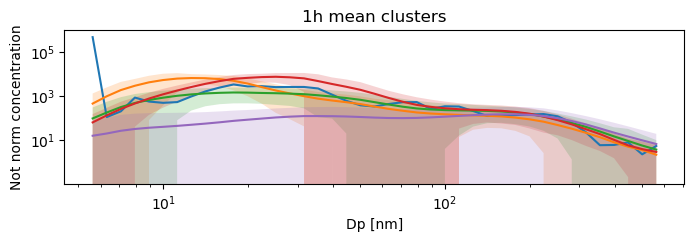

In [50]:
# Look at 1h mean clusters (from excluding the first bin)

# I have dropped two last columns + first (bins that is)
df_mean_1h_clusters = df_clustered_1h_mean.groupby('clusters').mean()
df_std_1h_clusters  = df_clustered_1h_mean.groupby('clusters').std()

fig, ax = plt.subplots(figsize=(8,2))

for i in range(n_clusters):
    ax.plot(diameters[1:-2]*10**9, df_mean_1h_clusters.iloc[i,:].values, '-')
    
    ax.fill_between(diameters[1:-2]*10**9, df_mean_1h_clusters.iloc[i,:].values+df_std_1h_clusters.iloc[i,:].values,                    
                        df_mean_1h_clusters.iloc[i,:].values-df_std_1h_clusters.iloc[i,:].values, alpha=0.2)
    
    #ax.plot(diameters*10**9, df_median_clusters.iloc[i,:].values, 'k-')
    #ax.set_xticks(bin_cols[::5])
    ax.set_xscale('log')
    ax.set_yscale('log')
    #ax.set_ylim(0,1.1)
plt.xlabel('Dp [nm]')
plt.title('1h mean clusters')
plt.ylabel('Not norm concentration')
plt.show()

In [51]:
df_mean_1h_clusters.head()

,5.623,6.31,7.079,7.943,8.913,10.0,11.22,12.589,14.125,15.849,...,199.526,223.872,251.189,281.838,316.228,354.813,398.107,446.684,501.187,562.341
clusters,,,,,,,,,,,,,,,,,,,,,
1,464628.720742,113.782961,205.915515,862.264425,570.142975,499.828810,539.213690,968.447780,1635.557250,2440.375550,...,149.240235,155.404095,122.589910,63.504685,23.509003,6.086729,6.240429,8.109983,2.354116,5.620107
2,462.004431,987.264712,1881.610598,2955.808487,4213.905785,5349.269123,6221.548461,6583.895865,6473.980989,5919.097921,...,89.947506,70.280095,49.637018,33.973184,22.172705,13.996756,8.259617,5.214298,3.670733,2.266226
3,98.493626,182.071200,320.648838,493.512626,672.786648,853.415374,1038.467110,1201.940047,1326.852462,1414.716793,...,154.155569,121.018474,88.086316,61.720587,41.002270,25.267820,15.228469,9.456728,5.872063,3.859162
4,65.177289,135.031864,265.144643,466.462355,780.953204,1214.156240,1792.051504,2590.188174,3602.033413,4783.536262,...,161.625497,119.682391,82.578106,53.181002,32.219969,19.324801,10.621293,5.994955,4.054997,3.026656
5,16.276309,20.576287,27.276199,32.914892,37.455737,41.155167,45.442932,51.030606,57.529012,65.805908,...,143.259778,126.894190,101.078690,75.293486,52.857771,34.911223,22.505260,14.963042,10.113037,6.882993


In [52]:
len(diameters[1:-2]*10**9)
print(df_mean_1h_clusters.shape)

(5, 41)


In [53]:
df_hourly_2010_2020_mean.iloc[:,1].values

array([1.92743870e+02, 1.82486285e+02, 1.41769720e+02, ...,
       2.47061390e-04, 1.23564450e-04, 2.46948720e-04])

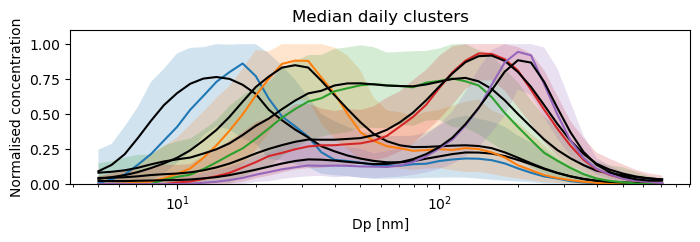

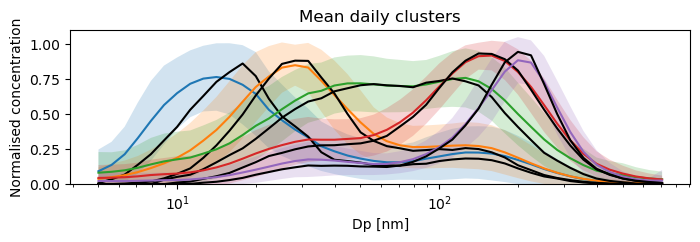

In [54]:
# Check to see how median clusters look like---------------------------------------


df_median_clusters = df_norm_clustered_median.groupby('clusters').median()
df_quantile10_clusters = df_norm_clustered_median.groupby('clusters').quantile(.1)
df_quantile90_clusters = df_norm_clustered_median.groupby('clusters').quantile(.9)

df_mean_clusters = df_norm_clustered_mean.groupby('clusters').mean()
df_std_clusters = df_norm_clustered_mean.groupby('clusters').std()


fig, ax = plt.subplots(figsize=(8,2))

for i in range(n_clusters):
    ax.plot(diameters*10**9, df_median_clusters.iloc[i,:].values, '-')
    ax.plot(diameters*10**9, df_mean_clusters.iloc[i,:].values, 'k-')
    ax.fill_between(diameters*10**9, df_quantile90_clusters.iloc[i,:].values,
                        df_quantile10_clusters.iloc[i,:].values, alpha=0.2)
    #ax.set_xticks(bin_cols[::5])
    ax.set_xscale('log')
    ax.set_ylim(0,1.1)
plt.xlabel('Dp [nm]')
plt.title('Median daily clusters')
plt.ylabel('Normalised concentration')
plt.show()

# Check to see how mean daily clusters look like---------------------------------------


fig, ax = plt.subplots(figsize=(8,2))

for i in range(n_clusters):
    ax.plot(diameters*10**9, df_mean_clusters.iloc[i,:].values, '-')
    ax.fill_between(diameters*10**9, df_mean_clusters.iloc[i,:].values+df_std_clusters.iloc[i,:].values,                    
                        df_mean_clusters.iloc[i,:].values-df_std_clusters.iloc[i,:].values, alpha=0.2)
    ax.plot(diameters*10**9, df_median_clusters.iloc[i,:].values, 'k-')
    #ax.set_xticks(bin_cols[::5])
    ax.set_xscale('log')
    ax.set_ylim(0,1.1)
    
    
plt.xlabel('Dp [nm]')
plt.title('Mean daily clusters')
plt.ylabel('Normalised concentration')
plt.show()



## Figures for presentation: 1h data Clusters

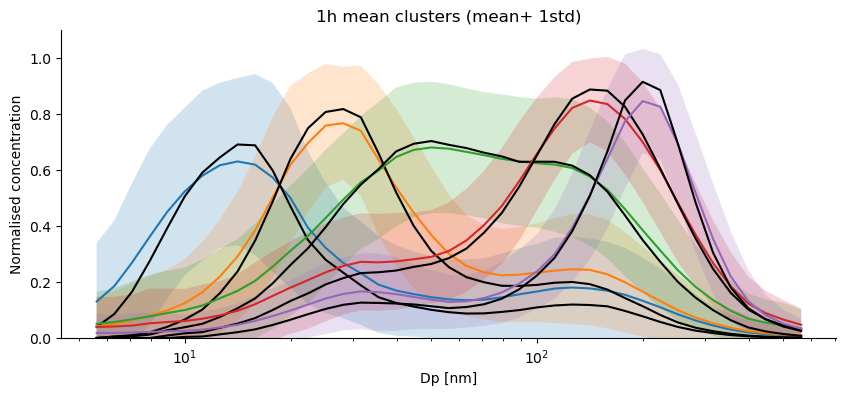

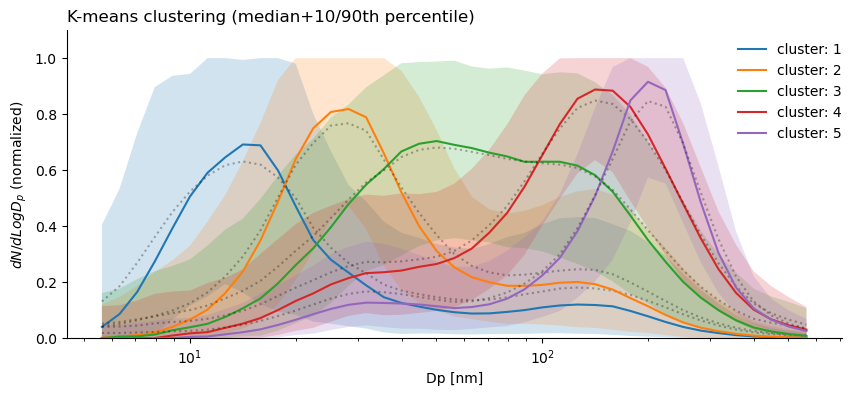

In [55]:
# Check to see how 1h mean clusters look like---------------------------------------
# !!! Note that columns have been dropped !!!! -------------------------------------

df_norm_clustered_1h_mean_median = df_norm_clustered_1h_mean.groupby('clusters').median()
df_norm_clustered_1h_10q = df_norm_clustered_1h_mean.groupby('clusters').quantile(.1)
df_norm_clustered_1h_90q = df_norm_clustered_1h_mean.groupby('clusters').quantile(.9)


df_norm_clustered_1h_mean_mean = df_norm_clustered_1h_mean.groupby('clusters').mean()
df_norm_clustered_1h_std = df_norm_clustered_1h_mean.groupby('clusters').std()

fig, ax = plt.subplots(figsize=(10,4))

for i in range(n_clusters):
    ax.plot(diameters[1:-2]*10**9, df_norm_clustered_1h_mean_mean.iloc[i,:].values, '-')
    ax.fill_between(diameters[1:-2]*10**9, 
                    df_norm_clustered_1h_mean_mean.iloc[i,:].values + df_norm_clustered_1h_std.iloc[i,:].values,                    
                    df_norm_clustered_1h_mean_mean.iloc[i,:].values - df_norm_clustered_1h_std.iloc[i,:].values, alpha=0.2)
    
    # Plot the median to see similarity
    ax.plot(diameters[1:-2]*10**9, df_norm_clustered_1h_mean_median.iloc[i,:].values, 'k-')
    #ax.set_xticks(bin_cols[::5])
    ax.set_xscale('log')
    ax.set_ylim(0,1.1)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
        ax.spines[spine].set_linewidth(3)
    
  
    
plt.xlabel('Dp [nm]')
plt.title('1h mean clusters (mean+ 1std)')
plt.ylabel('Normalised concentration')
plt.show()

# Median 1h mean clusters----------------------------------------------


fig, ax = plt.subplots(figsize=(10,4))

clusters = [1,2,3,4,5]

for cluster in clusters:
    #print(cluster)
    df_cluster = df_norm_clustered_1h_mean_median[df_norm_clustered_1h_mean_median.index == cluster]
    df_cluster_mean = df_norm_clustered_1h_mean_mean[df_norm_clustered_1h_mean_mean.index == cluster]
    df_cluster90 = df_norm_clustered_1h_90q[df_norm_clustered_1h_90q.index == cluster]
    df_cluster10 = df_norm_clustered_1h_10q[df_norm_clustered_1h_10q.index == cluster]
    
    ax.plot(diameters[1:-2]*10**9, df_cluster.iloc[0,:].values, '-', 
            label='cluster: '+str(cluster))
    ax.fill_between(diameters[1:-2]*10**9, 
                    df_cluster90.iloc[0,:].values,
                    df_cluster10.iloc[0,:].values,
                    alpha=0.2, )
    
    
    # Plot the mean to see similarity
    ax.plot(diameters[1:-2]*10**9, df_cluster_mean.iloc[0,:].values, 'k:',alpha=0.3)
    #ax.set_xticks(bin_cols[::5])
    ax.set_xscale('log')
    ax.set_ylim(0,1.1)
    

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
    ax.spines[spine].set_linewidth(0.5)
    
plt.xlabel('Dp [nm]')
plt.title('K-means clustering (median+10/90th percentile)', loc='left')
plt.ylabel('$dN/dLogD_p$ (normalized)')
plt.legend(frameon=False,bbox_to_anchor=(.85, 1))
plt.show()

In [56]:
#df_cluster.iloc[0,:].values

In [57]:
#df_norm_clustered_1h_90q

In [58]:
df_tmp.head()

,UFCPC,CPC3010,Ntot,5.012,5.623,6.31,7.079,7.943,8.913,10.0,...,446.684,501.187,562.341,630.957,707.946,flag,NtotCalc,NxNtot,ratio_CPCs,AbsDiffCPCs
DateTime,,,,,,,,,,,,,,,,,,,,,
2010-08-03,0.0,182.12505,208.743710,2.807274e-29,2.805087e-29,2.802623e-29,2.799847e-29,2.796717e-29,2.793188e-29,2.789083e-29,...,3.215610,0.065804,3.644812e-02,NaN,NaN,0.0,1.056546,0.005061,0.0,182.12505
2010-08-08,0.0,208.54903,216.002220,2.803765e-29,2.801642e-29,2.799177e-29,2.796336e-29,2.793333e-29,2.789739e-29,2.785956e-29,...,0.295609,0.018367,2.100116e-29,NaN,NaN,0.0,0.072130,0.000334,0.0,208.54903
2010-08-09,0.0,154.73486,161.003870,2.806636e-29,2.804662e-29,2.802281e-29,2.801081e-29,8.042767e-02,1.139879e+01,1.247090e+01,...,0.672033,0.344854,3.823051e-01,NaN,NaN,0.0,0.207218,0.001287,0.0,154.73486
2010-08-10,0.0,134.71979,131.968835,2.810195e-29,2.808443e-29,2.512165e+00,1.344979e+00,9.600177e-01,3.076694e+01,4.277998e+01,...,1.312853,0.653821,8.970167e-01,NaN,NaN,0.0,0.334995,0.002538,0.0,134.71979
2010-08-11,0.0,238.90039,235.042670,2.816689e-29,2.814186e-29,2.812867e-29,2.813508e-29,1.201330e+00,4.388591e+01,7.954211e+01,...,1.572773,1.200883,9.980769e-01,NaN,NaN,0.0,0.397748,0.001692,0.0,238.90039


### Look at trends in 1h mean data 

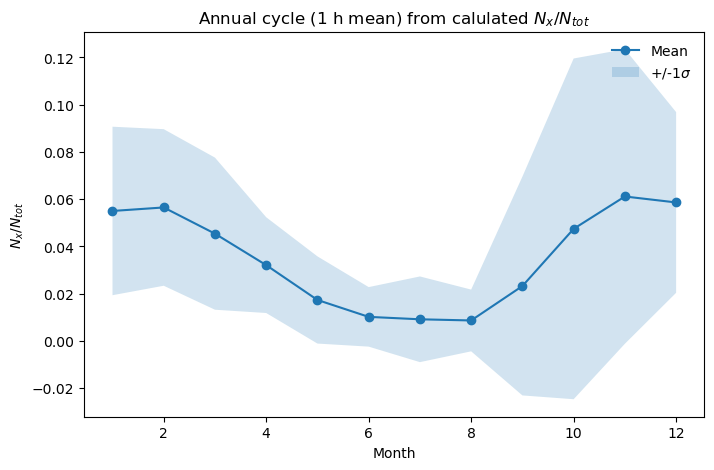

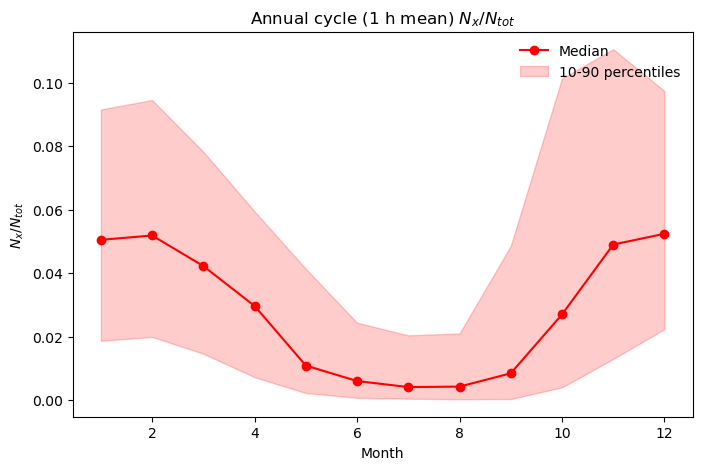

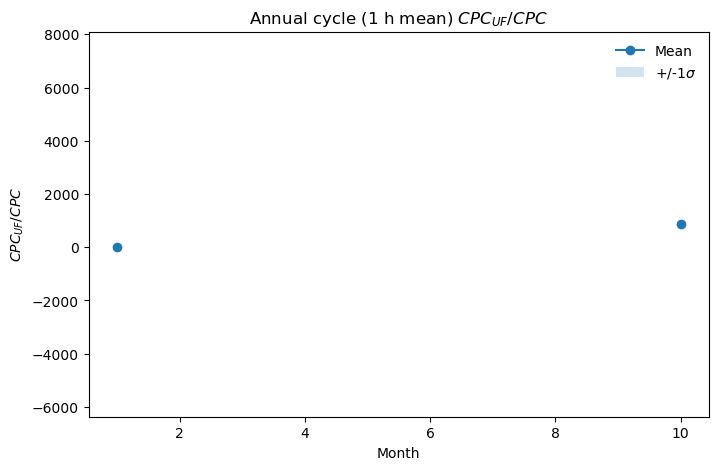

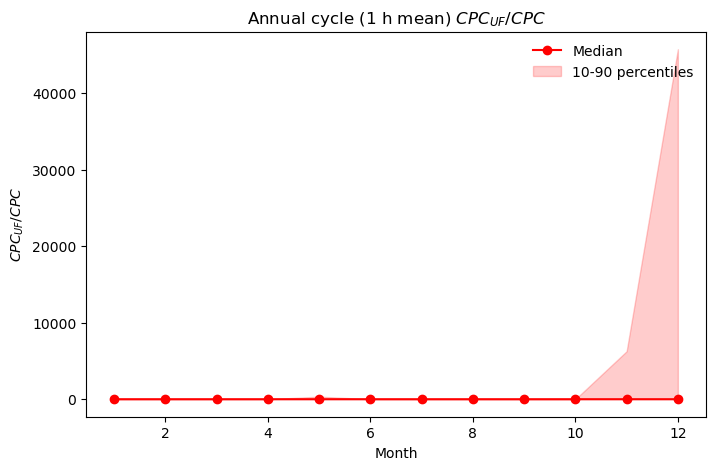

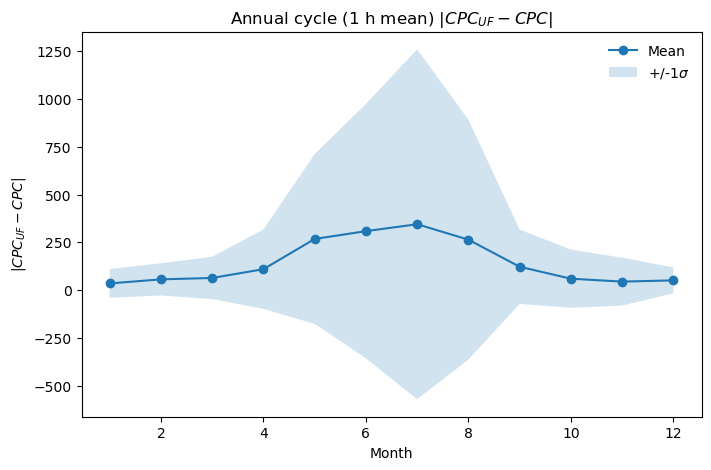

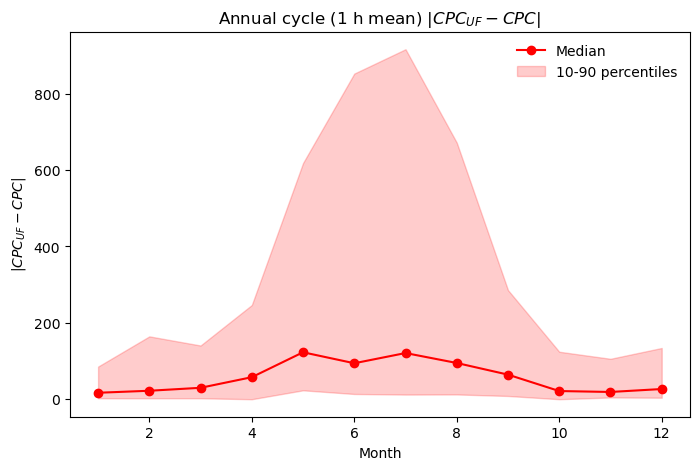

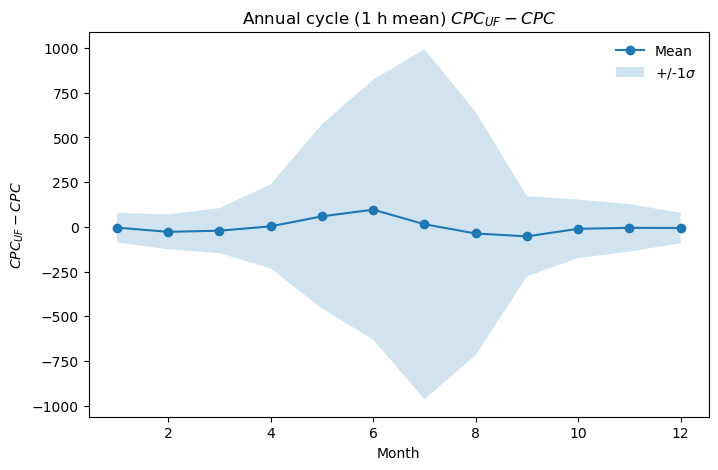

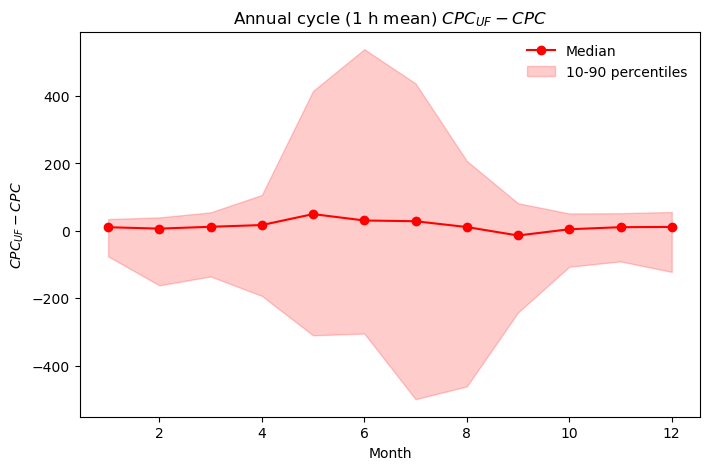

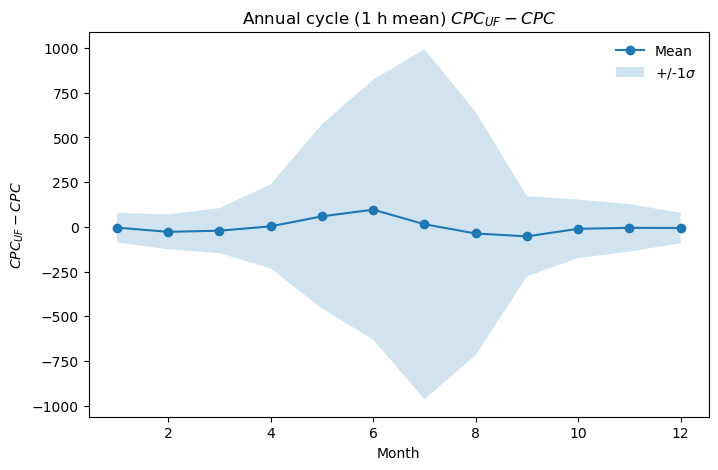

In [59]:
# Create temporary copy
df_tmp = df_hourly_2010_2020_mean.copy(deep = True)
# df_tmp = df_tmp.drop(columns=['UFCPC','CPC3010','Ntot','flag'])
# # =['UFCPC','5.012','630.957','707.946','CPC3010','Ntot','flag'])

# In temporary copy of mean data add columns: 


# Create Nx/Ntot for 1 h mean data

df_tmp = calcNtot(diameters[:len(bin_cols)+1], df_tmp)
df_tmp_nxntot = df_tmp.copy(deep = True)

df_tmp_nxntot['NxNtot'] = df_tmp_nxntot['NtotCalc']/df_tmp_nxntot['Ntot']

# Drop NaN:s
df_tmp_nxntot = df_tmp_nxntot.dropna(subset =['NxNtot'])

# Look at annual cycle for NxNtot
df_tmp_nxntot_mean = df_tmp_nxntot['NxNtot'].groupby(df_tmp_nxntot.index.month).mean()
df_tmp_nxntot_std = df_tmp_nxntot['NxNtot'].groupby(df_tmp_nxntot.index.month).std()

df_tmp_nxntot_median = df_tmp_nxntot['NxNtot'].groupby(df_tmp_nxntot.index.month).median()
df_tmp_nxntot_10q = df_tmp_nxntot['NxNtot'].groupby(df_tmp_nxntot.index.month).quantile(0.1)
df_tmp_nxntot_90q = df_tmp_nxntot['NxNtot'].groupby(df_tmp_nxntot.index.month).quantile(0.9)

# Create UF CPC/CPC ratio for 1 h mean data
df_tmp_rat =  df_tmp.copy(deep = True)
df_tmp_rat['ratio_CPCs'] = df_tmp_rat['UFCPC']/df_tmp_rat['CPC3010']

# Drop NaN:s
df_tmp_rat = df_tmp_rat.dropna(subset =['ratio_CPCs'])

df_1h_annual_cycle_rat_mean = df_tmp_rat['ratio_CPCs'].groupby(df_tmp_rat.index.month).mean()
df_1h_annual_cycle_rat_std = df_tmp_rat['ratio_CPCs'].groupby(df_tmp_rat.index.month).std()
8
df_1h_annual_cycle_rat_median = df_tmp_rat['ratio_CPCs'].groupby(df_tmp_rat.index.month).median()
df_1h_annual_cycle_rat_10q    = df_tmp_rat['ratio_CPCs'].groupby(df_tmp_rat.index.month).quantile(0.1)
df_1h_annual_cycle_rat_90q    = df_tmp_rat['ratio_CPCs'].groupby(df_tmp_rat.index.month).quantile(0.9)

# Create absolute diff Uf cpc - cpc----------------------------------------------------------

df_tmp['abs_diff'] = np.absolute(df_tmp['UFCPC']-df_tmp['CPC3010'])

df_tmp_adiff = df_tmp.copy(deep = True)

# Drop NaN's
df_tmp_adiff = df_tmp_adiff.dropna(subset =['abs_diff'])

df_1h_annual_cycle_adiff_mean = df_tmp_adiff['abs_diff'].groupby(df_tmp_adiff.index.month).mean()
df_1h_annual_cycle_adiff_std = df_tmp_adiff['abs_diff'].groupby(df_tmp_adiff.index.month).std()

df_1h_annual_cycle_adiff_median = df_tmp_adiff['abs_diff'].groupby(df_tmp_adiff.index.month).median()
df_1h_annual_cycle_adiff_10q = df_tmp_adiff['abs_diff'].groupby(df_tmp_adiff.index.month).quantile(0.1)
df_1h_annual_cycle_adiff_90q = df_tmp_adiff['abs_diff'].groupby(df_tmp_adiff.index.month).quantile(0.9)

# Create diff UFcpc and cpc----------------------------------------------------------

df_tmp['diff_cpcs'] = df_tmp['UFCPC']-df_tmp['CPC3010']

# Have to drop nans!!!!!!!

df_tmp_diff = df_tmp.copy(deep = True)
df_tmp_diff = df_tmp_diff.dropna(subset =['diff_cpcs'])

df_1h_annual_cycle_diff_mean = df_tmp_diff['diff_cpcs'].groupby(df_tmp_diff.index.month).mean()
df_1h_annual_cycle_diff_std = df_tmp_diff['diff_cpcs'].groupby(df_tmp_diff.index.month).std()

df_1h_annual_cycle_diff_median = df_tmp_diff['diff_cpcs'].groupby(df_tmp_diff.index.month).median()
df_1h_annual_cycle_diff_10q = df_tmp_diff['diff_cpcs'].groupby(df_tmp_diff.index.month).quantile(0.1)
df_1h_annual_cycle_diff_90q = df_tmp_diff['diff_cpcs'].groupby(df_tmp_diff.index.month).quantile(0.9)

#--------------------------------------------------------------------------------------------------

def makeTrendPlotsMean(dfMean, dfStd, xL, yL, tL):
    fig, axs = plt.subplots(1, figsize=(8, 5))
    axs.plot(dfMean.index, 
             dfMean.values,
             'o-', label= 'Mean')
    min_std = dfMean.values - dfStd.values
    #min_std[min_std<0]=0
    
    axs.fill_between(dfMean.index,
                dfMean.values + dfStd.values,
                min_std,
                alpha=0.2,label= '+/-1$\sigma$')
    axs.legend(frameon=False)
    axs.set_xlabel(xL)
    axs.set_ylabel(yL)
    axs.set_title(tL) 
    return fig, axs

def makeTrendPlotsMedian(dfMedian, dfUpperQ, dfLowerQ, UQ, LQ, xL, yL, tL):
    fig, axs = plt.subplots(1, figsize=(8, 5))
    axs.plot(dfMedian.index, 
             dfMedian.values,
             'ro-', label= 'Median')
    axs.fill_between(dfMedian.index,
                dfUpperQ,
                dfLowerQ,
                color ='r',alpha=0.2,label= str(LQ)+'-'+str(UQ)+' percentiles')
    axs.legend(frameon=False)
    axs.set_xlabel(xL)
    axs.set_ylabel(yL)
    axs.set_title(tL) 
    return fig, axs

# Plot ratios from calculated area ratio
fig1,axs1 = makeTrendPlotsMean(df_tmp_nxntot_mean,
                             df_tmp_nxntot_std,
                            'Month','$N_x/N_{tot}$',
                            'Annual cycle (1 h mean) from calulated $N_x/N_{tot}$')

fig12,axs12 = makeTrendPlotsMedian(df_tmp_nxntot_median,
                            df_tmp_nxntot_90q,
                            df_tmp_nxntot_10q,
                            90,10,'Month','$N_x/N_{tot}$',
                            'Annual cycle (1 h mean) $N_x/N_{tot}$')

# Plot cpc ratios

fig31,axs31 = makeTrendPlotsMean(df_1h_annual_cycle_rat_mean,
                             df_1h_annual_cycle_rat_std,
                            'Month','$CPC_{UF}/CPC$',
                            'Annual cycle (1 h mean) $CPC_{UF}/CPC$')

fig32,axs32 = makeTrendPlotsMedian(df_1h_annual_cycle_rat_median,
                                    df_1h_annual_cycle_rat_90q,
                                    df_1h_annual_cycle_rat_10q,
                                    90,10,
                                    'Month','$CPC_{UF}/CPC$',
                                    'Annual cycle (1 h mean) $CPC_{UF}/CPC$')

# Plot abs diff cpc:s

fig41,axs41 = makeTrendPlotsMean(df_1h_annual_cycle_adiff_mean,
                             df_1h_annual_cycle_adiff_std,
                            'Month','$|CPC_{UF}-CPC|$',
                            'Annual cycle (1 h mean) $|CPC_{UF}-CPC$|')

fig42,axs42 = makeTrendPlotsMedian(df_1h_annual_cycle_adiff_median,
                                    df_1h_annual_cycle_adiff_90q,
                                    df_1h_annual_cycle_adiff_10q,
                                    90,10,
                                    'Month','$|CPC_{UF}-CPC|$',
                                    'Annual cycle (1 h mean) $|CPC_{UF}-CPC$|')
axs42.plot()

# Plot diff cpc:s
fig52,axs52 = makeTrendPlotsMean(df_1h_annual_cycle_diff_mean,
                                     df_1h_annual_cycle_diff_std,
                                    'Month','$CPC_{UF}-CPC$',
                                    'Annual cycle (1 h mean) $CPC_{UF}-CPC$')

fig61,axs61 = makeTrendPlotsMedian(df_1h_annual_cycle_diff_median,
                                    df_1h_annual_cycle_diff_90q,
                                    df_1h_annual_cycle_diff_10q,
                                    90,10,
                                    'Month','$CPC_{UF}-CPC$',
                                    'Annual cycle (1 h mean) $CPC_{UF}-CPC$')

fig62,axs62 = makeTrendPlotsMean(df_1h_annual_cycle_diff_mean,
                                     df_1h_annual_cycle_diff_std,
                                    'Month','$CPC_{UF}-CPC$',
                                    'Annual cycle (1 h mean) $CPC_{UF}-CPC$')
# print(df_hourly_2010_2020_mean_copy.shape)

# # Create abs(UF_CPC-CPC ) for 1 h mean data 
# df_hourly_2010_2020_mean_copy['absDiff'] = np.absolute( df_tmp['UFCPC']-df_tmp['CPC3010'])
# print(df_hourly_2010_2020_mean_copy.shape)


df_cluster = df_tmp_adiff.copy(deep = 'true')
# Create a column called day of year (DoY) which gives the day of the year 1 to 366
df_cluster.loc[:,'DoY'] = df_cluster.index.dayofyear
df_cluster = df_cluster.dropna(subset =['DoY'])

# Calculate the occurence of cluster "cluster" per month
df_cluster_count = df_cluster.groupby('DoY').count()


# For presentation

C:\Users\Lovisa\AppData\Local\Temp\ipykernel_5076\1387823606.py:48: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  axs66.plot(df_cluster_count.index,
C:\Users\Lovisa\AppData\Local\Temp\ipykernel_5076\1387823606.py:48: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  axs66.plot(df_cluster_count.index,


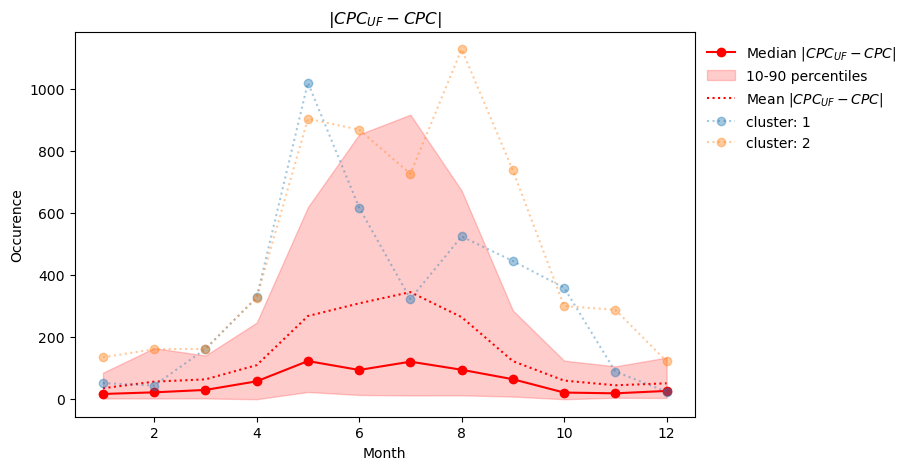

In [60]:
def makeTrendPlotsMedian2(dfMedian, dfUpperQ, dfLowerQ, UQ, LQ, xL, yL, tL):
    fig, axs = plt.subplots(1, figsize=(8, 5))
    axs.plot(dfMedian.index, 
             dfMedian.values,
             'ro-', label= 'Median $|CPC_{UF}-CPC$|')
    axs.fill_between(dfMedian.index,
                dfUpperQ,
                dfLowerQ,
                color ='r',alpha=0.2,label= str(LQ)+'-'+str(UQ)+' percentiles')
    axs.legend(frameon=False)
    axs.set_xlabel(xL)
    axs.set_ylabel(yL)
    axs.set_title(tL) 
    return fig, axs



# Plot abs diff cpc:s


fig66,axs66 = makeTrendPlotsMedian2(df_1h_annual_cycle_adiff_median,
                                    df_1h_annual_cycle_adiff_90q,
                                    df_1h_annual_cycle_adiff_10q,
                                    90,10,
                                    'Month','$|CPC_{UF}-CPC|$',
                                    '$|CPC_{UF}-CPC$|')
axs66.plot(df_1h_annual_cycle_adiff_mean.index,df_1h_annual_cycle_adiff_mean,'r',
          label = 'Mean $|CPC_{UF}-CPC$|', ls=':')
#axs66.legend(frameon=False) 


# Create a temporary copy of cluster-assigned data (normalized)
df_norm_clustered_1h_mean_copy = df_norm_clustered_1h_mean.copy()

clusters = [1, 2]


for cluster in clusters:
    df_cluster = df_norm_clustered_1h_mean_copy[df_norm_clustered_1h_mean_copy['clusters'] == cluster]
    df_cluster = df_cluster.copy()
    
    # Create a cloumn called month in dataframe
    df_cluster.loc[:,'month'] =  df_cluster.index.month
    
    # Calculate the occurence of cluster "cluster" per month
    df_cluster_count = df_cluster.groupby('month').count()
    
    axs66.plot(df_cluster_count.index, 
               df_cluster_count.iloc[:,0], 'o-', 
               label='cluster: '+str(cluster),
              alpha = 0.4, ls= ':')
    
    axs66.set_xlabel('Month')
    axs66.set_ylabel('Occurence')
    axs66.legend(frameon=False)
plt.legend(frameon=False,bbox_to_anchor=(1, 1))    
    

In [61]:
df_cluster_count.head()

,norm5.623,norm6.31,norm7.079,norm7.943,norm8.913,norm10.0,norm11.22,norm12.589,norm14.125,norm15.849,...,norm223.872,norm251.189,norm281.838,norm316.228,norm354.813,norm398.107,norm446.684,norm501.187,norm562.341,clusters
month,,,,,,,,,,,,,,,,,,,,,
1,135,135,135,135,135,135,135,135,135,135,...,135,135,135,135,135,135,135,135,135,135
2,161,161,161,161,161,161,161,161,161,161,...,161,161,161,161,161,161,161,161,161,161
3,162,162,162,162,162,162,162,162,162,162,...,162,162,162,162,162,162,162,162,162,162
4,327,327,327,327,327,327,327,327,327,327,...,327,327,327,327,327,327,327,327,327,327
5,903,903,903,903,903,903,903,903,903,903,...,903,903,903,903,903,903,903,903,903,903


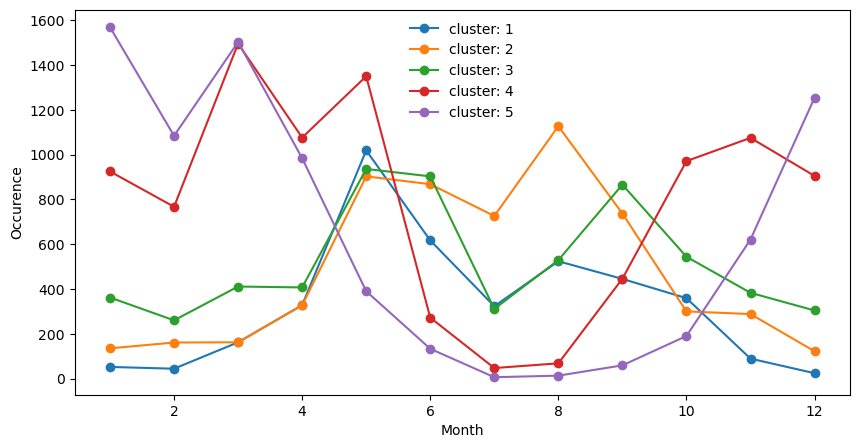

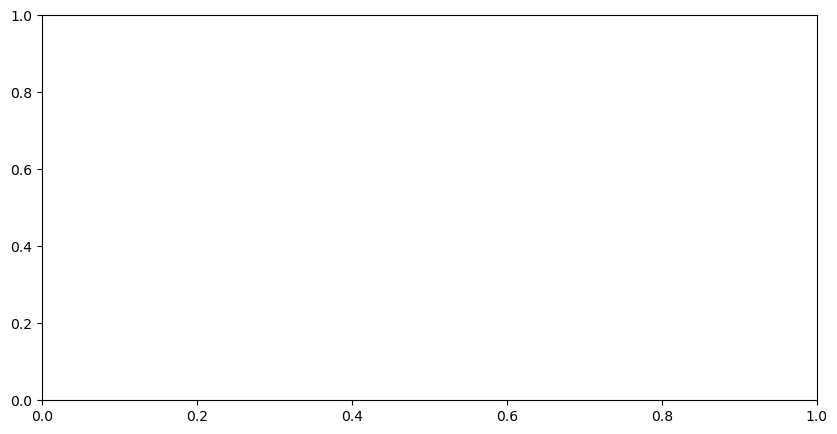

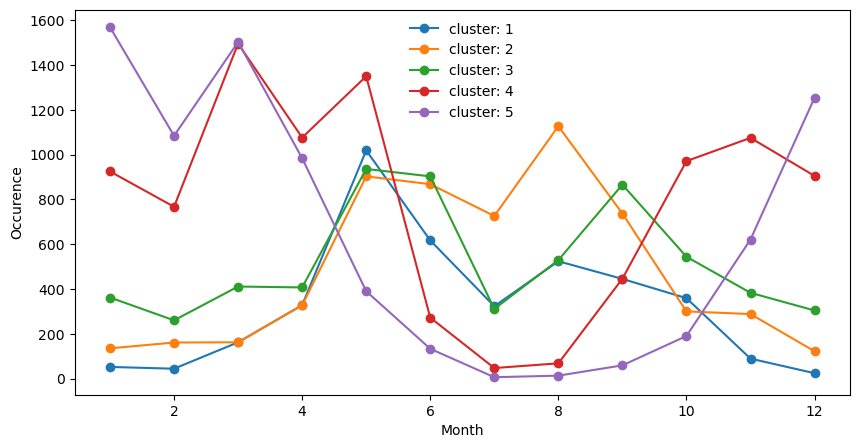

In [62]:
# Create a temporary copy of cluster-assigned data (normalized)
df_norm_clustered_1h_mean_copy = df_norm_clustered_1h_mean.copy()

clusters = [1, 2, 3, 4, 5]

fig, ax = plt.subplots(figsize=(10,5))

for cluster in clusters:
    df_cluster = df_norm_clustered_1h_mean_copy[df_norm_clustered_1h_mean_copy['clusters'] == cluster]
    df_cluster = df_cluster.copy()
    
    # Create a cloumn called month in dataframe
    df_cluster.loc[:,'month'] =  df_cluster.index.month
    
    # Calculate the occurence of cluster "cluster" per month
    df_cluster_count = df_cluster.groupby('month').count()
    
    ax.plot(df_cluster_count.index, df_cluster_count.iloc[:,0], 'o-', label='cluster: '+str(cluster))
    ax.set_xlabel('Month')
    ax.set_ylabel('Occurence')
    ax.legend(frameon=False)

fig, ax = plt.subplots(figsize=(10,5))

# Make stack plot from montly resample


fig, ax = plt.subplots(figsize=(10,5))

for cluster in clusters:
    df_cluster = df_norm_clustered_1h_mean_copy[df_norm_clustered_1h_mean_copy['clusters'] == cluster]
    df_cluster = df_cluster.copy()
    
    # Create a cloumn called month in dataframe
    df_cluster.loc[:,'month'] =  df_cluster.index.month
    
    # Calculate the occurence of cluster "cluster" per month
    df_cluster_count = df_cluster.groupby('month').count()
    
    ax.plot(df_cluster_count.index, df_cluster_count.iloc[:,0], 'o-', label='cluster: '+str(cluster))
    ax.set_xlabel('Month')
    ax.set_ylabel('Occurence')
    ax.legend(frameon=False)




# for cluster in clusters:
#     df_cluster = df_norm_clustered_1h_mean_copy[df_norm_clustered_1h_mean_copy['clusters'] == cluster]
#     df_cluster = df_cluster.copy()
    
#     # Create a column called day of year (DoY) which gives the day of the year 1 to 366
#     df_cluster.loc[:,'DoY'] = df_cluster.index.dayofyear
    
#     # Calculate the occurence of cluster "cluster" per month
#     df_cluster_count = df_cluster.groupby('DoY').count()
    
#     # Plot the occurence of cluster X vs the day of year
#     ax.plot(df_cluster_count.index, df_cluster_count.iloc[:,0], '-', label='cluster: '+str(cluster))
#     ax.set_xlabel('Day of Year')
#     ax.set_ylabel('Frequency')
#     ax.legend(frameon=False) 
    
# fig, ax = plt.subplots(figsize=(10,5))


# # Normalized

# for cluster in clusters:
#     df_cluster = df_norm_clustered_1h_mean_copy[df_norm_clustered_1h_mean_copy['clusters'] == cluster]
#     df_cluster = df_cluster.copy()
    
#     # Create a column called day of year (DoY) which gives the day of the year 1 to 366
#     df_cluster.loc[:,'DoY'] = df_cluster.index.dayofyear
    
#     # Calculate the occurence of cluster "cluster" per month
#     df_cluster_count = df_cluster.groupby('DoY').count()
    
#     # Plot the occurence of cluster X vs the day of year
#     ax.plot(df_cluster_count.index,
#             df_cluster_count.iloc[:,0]/df_cluster_count.iloc[:,0].max(),
#             '-', label='cluster: '+str(cluster))
    
#     ax.set_xlabel('Day of Year')
#     ax.set_ylabel('Normalized Frequency')
#     ax.legend(frameon=False) 
    



In [63]:
df_clusters_month = pd.DataFrame(columns=clusters)
print(df_clusters_month)
for cluster in clusters:
    df_cluster = df_norm_clustered_1h_mean_copy[df_norm_clustered_1h_mean_copy['clusters'] == cluster]
    df_cluster = df_cluster.copy()    
    df_cluster.loc[:,'month'] =  df_cluster.index.month    
    # Calculate the occurence of cluster "cluster" per month
    df_cluster_count = df_cluster.groupby('month').count()    
    monthly_occurance = df_cluster_count.iloc[:,0].values
    print(monthly_occurance)
    df_clusters_month[cluster] = monthly_occurance
    
df_clusters_month['total_freq'] = df_clusters_month.sum(axis=1)
df_clusters_month = df_clusters_month.div(df_clusters_month['total_freq'], axis=0)    

Empty DataFrame
Columns: [1, 2, 3, 4, 5]
Index: []
[  52   44  162  328 1019  617  323  524  445  359   89   24]
[ 135  161  162  327  903  868  726 1127  737  300  288  122]
[362 260 411 407 936 903 311 529 866 544 383 304]
[ 925  767 1496 1076 1350  272   47   68  446  971 1075  905]
[1569 1084 1503  984  390  133    6   13   59  190  621 1254]


In [64]:
df_clusters_month

,1,2,3,4,5,total_freq
0,0.017088,0.044364,0.118962,0.303976,0.515610,1.0
1,0.018998,0.069516,0.112263,0.331174,0.468048,1.0
2,0.043385,0.043385,0.110070,0.400643,0.402517,1.0
3,0.105061,0.104741,0.130365,0.344651,0.315183,1.0
4,0.221618,0.196390,0.203567,0.293606,0.084819,1.0
5,0.220909,0.310777,0.323308,0.097386,0.047619,1.0
6,0.228592,0.513800,0.220099,0.033263,0.004246,1.0
7,0.231756,0.498452,0.233967,0.030075,0.005750,1.0
8,0.174305,0.288680,0.339209,0.174696,0.023110,1.0
9,0.151861,0.126904,0.230118,0.410745,0.080372,1.0


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'Jan'),
  Text(1, 0, 'Feb'),
  Text(2, 0, 'Mar'),
  Text(3, 0, 'Apr'),
  Text(4, 0, 'May'),
  Text(5, 0, 'Jun'),
  Text(6, 0, 'Jul'),
  Text(7, 0, 'Aug'),
  Text(8, 0, 'Sept'),
  Text(9, 0, 'Oct'),
  Text(10, 0, 'Nov'),
  Text(11, 0, 'Dec')])

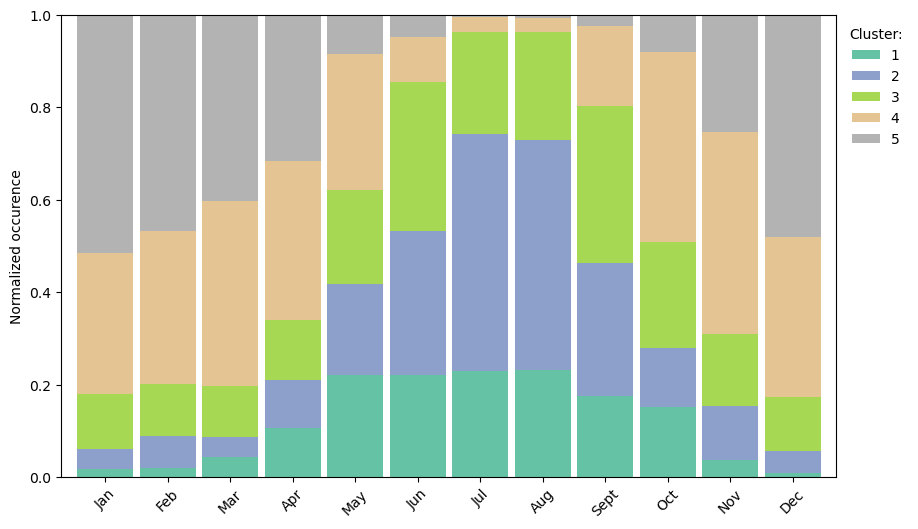

In [65]:
df_clusters_month[clusters].plot(kind='bar', 
                    stacked=True, 
                    colormap='Set2',
                    width = 0.9,            
                    figsize=(10, 6))



plt.ylabel("Normalized occurence")
plt.ylim(0,1)
plt.legend(title = 'Cluster:',frameon=False,bbox_to_anchor=(1, 1))
plt.xticks(np.arange(0, 12, 1), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'],)
plt.xticks(rotation = 45)

In [66]:
df_cluster.loc[:,'date'] = df_cluster.index.map(datetime.datetime.toordinal) 
df_cluster.loc[:,'date'] = df_cluster.loc[:,'date'] - df_cluster.loc[:,'date'][0] + 1

### Make nice MJJ trend

In [67]:
df_trend = df_norm_clustered_1h_mean_copy.copy()

# df_trend['Month'] = df_trend.index
# df_trend['Year']  =
dt_array = df_trend.index.values
df_trend['dtObjects'] = dt_array
df_trend['month_year'] = pd.to_datetime(df_trend['dtObjects']).dt.to_period('M')
df_trend['month'] = df_trend['dtObjects'].dt.month
df_trend['year'] = df_trend['dtObjects'].dt.year

clusters = [1, 2, 3, 4, 5]

# Create a dataframe from dictionaries as sometimes ther might not be any cluster 3 for example in some month --> 
# Problem that when we group by month-year we don't get the 

list_of_dicts = []
for cluster in clusters:
    df_cluster = df_trend[df_trend['clusters'] == cluster]
    df_cluster = df_cluster.copy()    
    #print(cluster)   
    # Calculate the occurence of cluster "cluster" per month
    df_cluster_count  = df_cluster.groupby('month_year').count()    
    monthly_occurance = df_cluster_count.iloc[:,0].values
    
    
    dict_cluster = dict(zip(df_cluster_count.index, monthly_occurance))
    
    #print(dict_cluster)
    list_of_dicts.append(dict_cluster)
    #print(list_of_dicts)

# ds is a dataframe whcih contains the rows = cluster no, and rows equal to month-year. 
df_clusters_seqMonth = pd.DataFrame(list_of_dicts)
#     print(monthly_occurance)
#     df_clusters_seqmonth[cluster] = monthly_occurance


In [68]:
type(df_trend.index.values)

numpy.ndarray

In [69]:
# The days that have zero count get a Nan values that should be replaced by 0
df_clusters_seqMonth = df_clusters_seqMonth.replace(np.nan, 0)

df_clusters_seqMonth.loc['total'] = df_clusters_seqMonth.sum(axis=0)

In [70]:
df_clusters_seqMonth

,2010-11,2010-12,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,...,2019-09,2020-12,2014-04,2015-04,2019-11,2019-12,2011-01,2019-01,2019-10,2020-02
0,1.0,4.0,10.0,2.0,9.0,80.0,68.0,73.0,113.0,51.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.0,11.0,33.0,14.0,36.0,35.0,169.0,209.0,177.0,266.0,...,13.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14.0,37.0,66.0,26.0,2.0,80.0,137.0,84.0,229.0,279.0,...,71.0,33.0,1.0,1.0,12.0,1.0,0.0,0.0,0.0,0.0
3,72.0,149.0,161.0,186.0,1.0,200.0,37.0,0.0,27.0,52.0,...,22.0,28.0,100.0,32.0,12.0,133.0,124.0,2.0,19.0,2.0
4,129.0,66.0,276.0,94.0,0.0,50.0,39.0,0.0,2.0,4.0,...,0.0,3.0,190.0,57.0,0.0,68.0,178.0,27.0,0.0,82.0
total,221.0,267.0,546.0,322.0,48.0,445.0,450.0,366.0,548.0,652.0,...,106.0,72.0,291.0,90.0,24.0,202.0,302.0,29.0,19.0,84.0


In [71]:
str(df_clusters_seqMonth.columns.values[0])
datetimes = [pd.to_datetime(str(x)) for x in list(df_clusters_seqMonth.columns.values)]

In [72]:
# Transform the data frame so clusters are columns 
df_T = df_clusters_seqMonth.T
df_T.index = datetimes
df_T['month'] = df_T.index.month

In [73]:
df_T.columns = ['1','2','3','4','5','total', 'month']
df_T_summer = df_T[df_T.month.isin([5,6,7])] # Choosing the months

In [74]:
df_T_summer = df_T_summer.sort_index()

In [75]:
df_norm_summer = df_T_summer[['1', '2', '3', '4', '5']].div(df_T_summer['total'], axis=0)

In [76]:
df_norm_summer.head()

,1,2,3,4,5
2011-05-01,0.179775,0.078652,0.179775,0.449438,0.112360
2011-06-01,0.151111,0.375556,0.304444,0.082222,0.086667
2011-07-01,0.199454,0.571038,0.229508,0.000000,0.000000
2012-05-01,0.263248,0.138462,0.198291,0.282051,0.117949
2012-06-01,0.242070,0.447412,0.173623,0.080134,0.056761


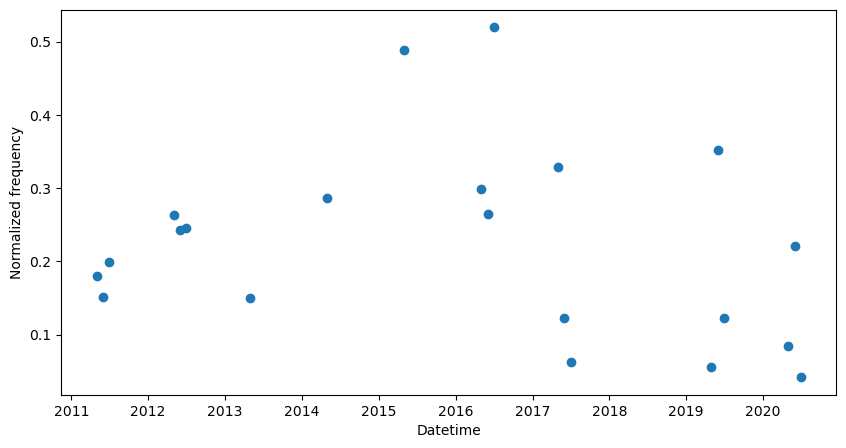

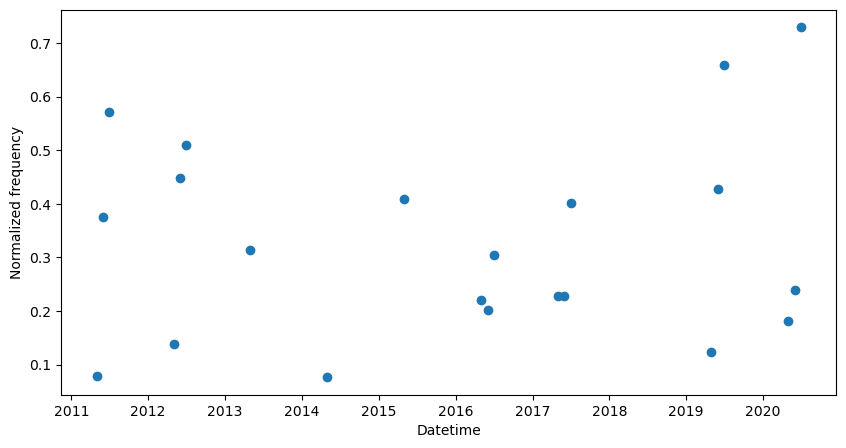

---------------------------
Theil-Sen slope
Slope: 0.0032734004926647953
Intercept: 0.271187563700803
Lower bound of the confidence interval on medslopeLower: -0.012339825635318113
Upper bound of the confidence interval on medslopeLower: 0.0204790802940175
---------------------------


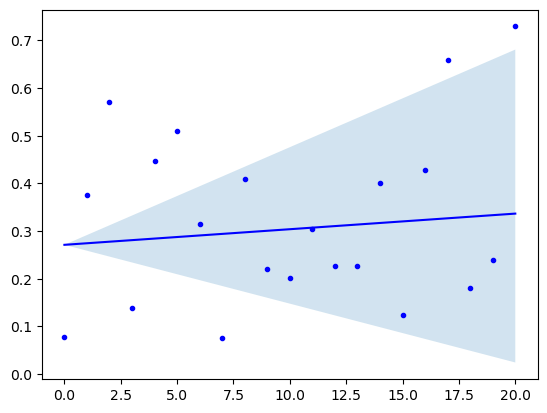

In [77]:
# Trend for MJJ

fig, ax = plt.subplots(figsize=(10,5))

ax.plot(df_norm_summer.index,df_norm_summer['1'].values,'o' )
ax.set_ylabel('Normalized frequency')
ax.set_xlabel('Datetime')
plt.show()

fig, ax = plt.subplots(figsize=(10,5))

#-----------Choosing the clusters---------------------------

cluster_name = '2'


ax.plot(df_norm_summer.index,
        df_norm_summer[cluster_name].values,
        'o',label='original data') 
ax.set_ylabel('Normalized frequency')
ax.set_xlabel('Datetime')
plt.show()

# Fit a lin regression slope is not what we want -we don't want correlation -we want trend
varx = np.arange(len(df_norm_summer.index))
vary = df_norm_summer[cluster_name].values

# # # mask = ~np.isnan(varx) & ~np.isnan(vary)
# res = sc.stats.linregress(varx, vary)

# print(f"R-squared: {res.rvalue**2:.6f}")

# fig, ax = plt.subplots(figsize=(10,5))
# plt.plot(varx,
#          vary,
#          'o', label='original data')
# plt.plot(varx,
#          res.intercept + res.slope*varx,
#          'r-', label='fitted line')
# plt.legend()
# plt.show()    
# plt.ylabel('N_tot')
# plt.xlabel('N_tot_calc')


# For trend analysis we use theil zen slope
slope, intercept, lo_slope, up_slope  = sc.stats.theilslopes(vary, varx, 0.95)

# medslope :Theil slope.
# medintercept : Intercept of the Theil line, as median(y) - medslope*median(x).
# lo_slope : Lower bound of the confidence interval on medslope.
# up_slope : Upper bound of the confidence interval on medslope.

print('---------------------------')
print('Theil-Sen slope')
print('Slope:',slope)
print('Intercept:',intercept)
print('Lower bound of the confidence interval on medslopeLower:',lo_slope)
print('Upper bound of the confidence interval on medslopeLower:',up_slope)
print('---------------------------')

# Plot the Theil-Sen slope (non-parametric)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(varx, vary, 'b.',label='original data')
ax.plot(varx, intercept + slope * varx, 'b-')

ax.fill_between(varx, 
               intercept + up_slope * varx,
               intercept + lo_slope * varx,
               alpha=0.2, label= '95% Confidence $')
plt.show()
ax.legend()

# Test the sign of the slope



In [78]:
df_norm_summer['year'] = df_norm_summer.index.year
df_norm_summer['year'] = df_norm_summer['year'] - df_norm_summer['year'].iloc[0]
df_norm_summer['month'] = df_norm_summer.index.month
df_norm_summer['month_ordered'] = df_norm_summer['year']*12 + df_norm_summer['month'] 
df_norm_summer['month_ordered'] = df_norm_summer['month_ordered'] - df_norm_summer['month_ordered'].iloc[0] + 1

In [79]:
df_norm_summer

,1,2,3,4,5,year,month,month_ordered
2011-05-01,0.179775,0.078652,0.179775,0.449438,0.112360,0,5,1
2011-06-01,0.151111,0.375556,0.304444,0.082222,0.086667,0,6,2
2011-07-01,0.199454,0.571038,0.229508,0.000000,0.000000,0,7,3
2012-05-01,0.263248,0.138462,0.198291,0.282051,0.117949,1,5,13
2012-06-01,0.242070,0.447412,0.173623,0.080134,0.056761,1,6,14
2012-07-01,0.245968,0.509409,0.216398,0.025538,0.002688,1,7,15
2013-05-01,0.150250,0.313856,0.210351,0.247078,0.078464,2,5,25
2014-05-01,0.286290,0.076613,0.020161,0.354839,0.262097,3,5,37
2015-05-01,0.488095,0.408730,0.051587,0.051587,0.000000,4,5,49
2016-05-01,0.298246,0.220760,0.222222,0.238304,0.020468,5,5,61


In [80]:
#slice
df_norm_summer = df_norm_summer[df_norm_summer.index.year < 2018]

C:\Users\Lovisa\AppData\Local\Temp\ipykernel_5076\3343075962.py:23: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "x-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(df_norm_summer.index, df_norm_summer[cluster_name].values, 'x-', ls=':')
C:\Users\Lovisa\AppData\Local\Temp\ipykernel_5076\3343075962.py:27: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(varx, intercept + slope * varx, 'b-', ls='-', alpha=1,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


---------------------------
Theil-Sen slope
Slope: -0.00026709401709401615
Intercept: 0.31380404725992955
Lower bound of the confidence interval on medslopeLower: -0.0037276514897062875
Upper bound of the confidence interval on medslopeLower: 0.003633385213454718
---------------------------


(0.0, 1.0)

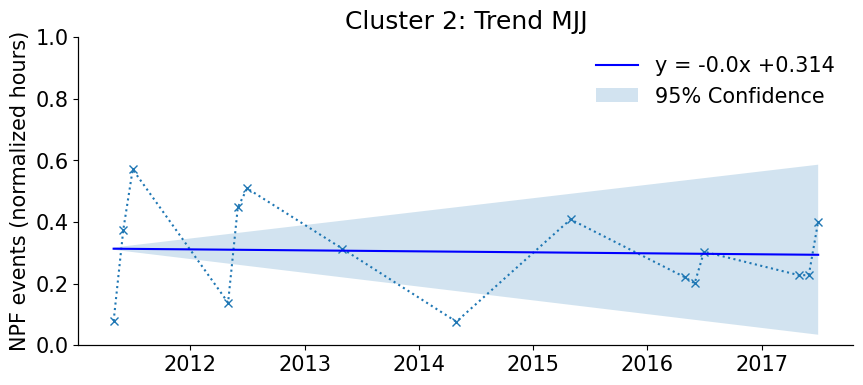

In [81]:
cluster_name = '2'

# Fit a lin regression slope is not what we want -we don't want correlation -we want trend
varx = df_norm_summer['month_ordered'].values
vary = df_norm_summer[cluster_name].values

# For trend analysis we use theil zen slope
slope, intercept, lo_slope, up_slope  = sc.stats.theilslopes(vary, varx, 0.95)

print('---------------------------')
print('Theil-Sen slope')
print('Slope:',slope)
print('Intercept:',intercept)
print('Lower bound of the confidence interval on medslopeLower:',lo_slope)
print('Upper bound of the confidence interval on medslopeLower:',up_slope)
print('---------------------------')

plt.rcParams['font.size'] = '15'
# Plot the Theil-Sen slope (non-parametric)
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(111)
ax.plot(df_norm_summer.index, df_norm_summer[cluster_name].values, 'x-', ls=':')
ax.set_ylabel('NPF events (normalized hours)')

ax2 = ax.twiny()
ax2.plot(varx, intercept + slope * varx, 'b-', ls='-', alpha=1, 
         label='y = '+str( round(slope, 3) )+'x +' +str(round(intercept,3) ))
ax2.fill_between(varx, 
               intercept + up_slope * varx,
               intercept + lo_slope * varx,
               alpha=0.2, label= '95% Confidence')
#ax.set_ylim(0,1)
ax2.set_xticks([])
ax2.set_title('Cluster 2: Trend MJJ')

for ax in [ax, ax2]:
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.legend(frameon=False)

# no = 10
# t = pd.date_range(start='2011-05-01',
#                   end='2021-05-01',
#                   periods=11)
# x_val_months = range(1,122,11)

#ax.set_xticks(df_norm_summer['month_ordered'].values[::6],  df_norm_summer.index[::6])

plt.ylim(0, 1)






C:\Users\Lovisa\AppData\Local\Temp\ipykernel_5076\3288565969.py:22: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "rx-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(df_norm_summer.index, df_norm_summer[cluster_name].values, 'rx-', ls=':')
C:\Users\Lovisa\AppData\Local\Temp\ipykernel_5076\3288565969.py:26: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  ax2.plot(varx, intercept + slope * varx, 'r-', ls='-', alpha=1,
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


---------------------------
Theil-Sen slope
Slope: 0.0011952233441202547
Intercept: 0.20174447820303446
Lower bound of the confidence interval on medslopeLower: -0.0017550083472454093
Upper bound of the confidence interval on medslopeLower: 0.0038742331771697658
---------------------------


(0.0, 1.0)

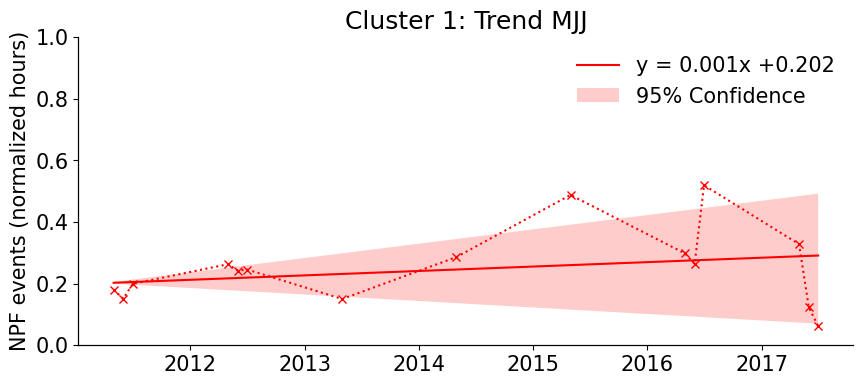

In [82]:
cluster_name = '1'

# Fit a lin regression slope is not what we want -we don't want correlation -we want trend
varx = df_norm_summer['month_ordered'].values
vary = df_norm_summer[cluster_name].values

# For trend analysis we use theil zen slope
slope, intercept, lo_slope, up_slope  = sc.stats.theilslopes(vary, varx, 0.95)

print('---------------------------')
print('Theil-Sen slope')
print('Slope:',slope)
print('Intercept:',intercept)
print('Lower bound of the confidence interval on medslopeLower:',lo_slope)
print('Upper bound of the confidence interval on medslopeLower:',up_slope)
print('---------------------------')

# Plot the Theil-Sen slope (non-parametric)
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(111)
ax.plot(df_norm_summer.index, df_norm_summer[cluster_name].values, 'rx-', ls=':')
ax.set_ylabel('NPF events (normalized hours)')

ax2 = ax.twiny()
ax2.plot(varx, intercept + slope * varx, 'r-', ls='-', alpha=1, 
         label='y = '+str( round(slope, 3) )+'x +' +str(round(intercept,3) ))
ax2.fill_between(varx, 
               intercept + up_slope * varx,
               intercept + lo_slope * varx,
               alpha=0.2, label= '95% Confidence',
                facecolor = 'r')
#ax.set_ylim(0,1)
ax2.set_xticks([])
ax2.set_title('Cluster 1: Trend MJJ')

for ax in [ax, ax2]:
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    ax.legend(frameon=False)

# no = 10
# t = pd.date_range(start='2011-05-01',
#                   end='2021-05-01',
#                   periods=11)
# x_val_months = range(1,122,11)

#ax.set_xticks(df_norm_summer['month_ordered'].values[::6],  df_norm_summer.index[::6])

plt.ylim(0, 1)




## Attempt to integrate with trapezoidal rule to find the ratio $N_{<30}/N_{tot}$

In [83]:
# diameter_list = list(diameters)
# df_daily_2010_2020_median[cols]

# df_daily_2010_2020_median['diameter_list'].values

In [84]:
# This array will contain the trpezioidal integration of total distribution 
ntot_trap_mean = 9999*np.ones((1,len(df_daily_2010_2020_mean))) 


In [85]:
# Integrating over all daily median distributions = N_tot daily

# bin_cols = get_bins(bin_col_names_2010_2020)

# def add_trapz_integration(diameters, df_daily_2010_2020_median):
    
#     list_of_areas = []
#     diameter_list = list(diameters)
    
#     for i in np.arange(0,len(df_daily_2010_2020_median)):
#         df_tmp_median = df_daily_2010_2020_median.iloc[i, 3:-1]
        
#         ys = df_tmp_median.values[~np.isnan(df_tmp_median.values)]
#         xs = np.array(diameters[~np.isnan(df_tmp_median.values)])
                
#         trap_tmp = np.trapz(ys, , dx=1.0, axis=- 1)
        
#         # Becuse we integrate over the lognormal distribution, we have to denormalize by multiplying 
#         list_of_areas.append(trap_tmp)
    
#     # Make a copy of dataframe to wich the trapz area is added
#     df_with_added_area = df_daily_2010_2020_median.copy(deep = True)
#     df_with_added_area['area'] = list_of_areas
# return df_with_added_area

In [86]:
#df_trapz_area_median = add_trapz_integration(df_daily_2010_2020_median)

## Compare the trapz integration 
#### (should correspond to the $N_{tot}$ dataframe column)

In [87]:
# # I want to make a scatter plot 


# plt.plot(df_trapz_area_median['area'].values, df_trapz_area_median['Ntot'],'o')
# plt.xlabel('Trapezoidal area')
# plt.ylabel('$N_{tot}$')